In [1]:
import random
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from copy import copy, deepcopy
from itertools import product
from tqdm import tqdm
from scipy.spatial import ConvexHull


from models.geophysic_models.carbon_cycle_models import *
from models.geophysic_models.temperature_dynamic_model import *
from models.geophysic import *
from models.game_theory.benefit_function import *
from models.game_theory.damage_function import *
from models.game_theory.strategies import *


from models.game import *
from plot_function import *

sns.set_style('ticks',  {"axes.grid" : "True", "grid.color": ".4", "grid.linestyle": ":"})
sns.set_context("paper")
plt.rcParams.update({'mathtext.default':  'regular' })
plt.rcParams['xtick.direction'] = 'out'


carbon_model = Carbon_DICE_2016R()
temperature_model = Temp_DICE_2016R()
smc = geophysics(carbon_model, temperature_model)

# Nombre de joueur 
N = 5

# Espaces d'action des joueurs en GtCO2

action_sets = np.array([[0.0, 12.0],        # China  
                        [0.0, 8.0],         # USA
                        [0.0, 5.0],         # EU
                        # [0.0, 4.0],         # India
                        [0.0, 7.0],         # Russia
                        [0.0, 9.0]])        # other Asia    

# Coefficient d'impact de la temperature sur le climat 

deltas = np.array([1.1847,
                    1.1941,
                    1.1248,
                    # 0.9074,
                    1.2866,
                    1.1847]) 

# PIB max des joueurs, j'ai pris le PIB 2020                

gdp_max = np.array([15.0,
                    18.0,
                    17.0,
                    # 2.6,
                    1.6,
                    26.0])*1

omegas = gdp_max/np.sum(gdp_max)

alpha =1

In [2]:
indice_1 = 0
indice_2 = 1

In [21]:
def process(list_product_strategy_profile, smc, list_players) : 
    data_utilities = []
    data_actions_profiles = []
    for strategy in tqdm(list_product_strategy_profile, 'Processing'):
        game = Game(deepcopy(smc), list_players)
        game.repeated_one_shot_game_with_strategies_profile(strategy)
        data_utilities.append(game.strat_utilities_profiles)
        data_actions_profiles.append(game.strat_action_profiles)
    return data_utilities, data_actions_profiles

def process_one_shot(list_product_strategy_profile, product_strategy_sum, smc, list_players) : 
    data_utilities = []
    for idx in tqdm(range(len(product_strategy_sum)), 'Processing'):
        strategy = list_product_strategy_profile[idx]
        strat_sum = product_strategy_sum[idx]
        game = Game(deepcopy(smc), list_players)
        utilities = game.one_shot_game_with_strategies_profile(strategy,strat_sum, smc)
        data_utilities.append(utilities)
    return data_utilities

def process_following(following, smc, list_players) : 
    data_follow_utilities = []
    data_follow_actions = []
    for time in range(T):
        data_utilities = []
        data_actions_profiles = []
        list_product_strategy_profile = following[time]
        for strategy in tqdm(list_product_strategy_profile, 'Processing'):
            game = Game(deepcopy(smc), list_players)
            game.repeated_one_shot_game_with_strategies_profile(strategy)
            data_utilities.append(game.strat_utilities_profiles)
            data_actions_profiles.append(game.strat_action_profiles)
        data_follow_utilities.append(data_utilities)
        data_follow_actions.append(data_actions_profiles)
    return data_follow_utilities, data_follow_actions



In [22]:
def pareto_domine(NE_utilities, strat_utilities):
    for i in range(len(NE_utilities)) :
        if NE_utilities[i] > strat_utilities[i] :
            return False
    return True

delta_step = 5

def pareto_domine_uptill_time(profile_NE_utilities, profile_strat_utilities, time):
    for t in range(time):
        if not pareto_domine(profile_NE_utilities[:,t], profile_strat_utilities[:,t]):
            return False
    return True 

def pareto_domine_over_delta(NE_utilities, strat_utilities, delta):
    for i in range(len(NE_utilities)) :
        tsup = min(i + delta, len(NE_utilities))
        if np.sum(NE_utilities[i:tsup]) > np.sum(strat_utilities[i:tsup]) :
            return False
    return True

def pareto_domine_over_time(profile_NE_utilities, profile_strat_utilities):
    n,tmax = np.shape(profile_NE_utilities)
    for time in range(tmax):
        if not pareto_domine(profile_NE_utilities[:,time], profile_strat_utilities[:,time]):
            return False
    return True 

def pareto_domine_sum_utility(NE_utilities, strat_utilities):
    for i in range(len(NE_utilities)) :
        if NE_utilities[i] > strat_utilities[i] :
            return False
    return True

In [33]:
def sort_data(data_u, data_a, utilities_NE) :
    pareto_strict_u = []
    pareto_strict_a = []
    pareto_sum_u = []
    pareto_sum_a = []

    for idx in range(len(data_u)):
        profile_u = data_u[idx]
        profile_a = data_a[idx]
        if pareto_domine_over_time(utilities_NE, profile_u):
            pareto_strict_u.append(profile_u)
            pareto_strict_a.append(profile_a)

        if pareto_domine_sum_utility(np.sum(utilities_NE,axis=1), np.sum(profile_u,axis=1)):
            pareto_sum_u.append(profile_u)
            pareto_sum_a.append(profile_a)

    pareto_up_u = []
    pareto_up_a = []
    for time in range(T):
        pareto_up_time_u = []
        pareto_up_time_a = []
        for idx in range(len(data_u)):
            profile_u = data_u[idx]
            profile_a = data_u[idx]

            if pareto_domine_uptill_time(utilities_NE, profile_u, time+1):
                pareto_up_time_u.append(profile_u)
                pareto_up_time_a.append(profile_a)

        pareto_up_u.append(pareto_up_time_u)
        pareto_up_a.append(pareto_up_time_a)

    print('Num strat Pareto every step :', len(pareto_strict_u))
    print('Num strat Pareto in sum :', len(pareto_sum_u))

    return pareto_strict_u, pareto_strict_a, pareto_sum_u, pareto_sum_a


def sort_follow(following_u, following_a, utilities_NE):
    pareto_at_u = []
    pareto_at_a = []
    pareto_delta_u = []
    pareto_delta_a = []
    pareto_sum_u = []
    pareto_sum_a = []
    for time in range(T):

        data_u = following_u[time]
        data_a = following_a[time]

        pareto_at_time_u = []
        pareto_at_time_a = []
        pareto_delta_time_u = []
        pareto_delta_time_a = []
        pareto_sum_time_u = []
        pareto_sum_time_a = []

        for idx in range(len(data_u)):
            profile_u = data_u[idx]
            profile_a = data_a[idx]
            if pareto_domine(utilities_NE[:,time], profile_u[:,time]):
                pareto_at_time_u.append(profile_u)
                pareto_at_time_a.append(profile_a)

            if pareto_domine_over_delta(utilities_NE, profile_u, delta=delta_step):
                pareto_delta_time_u.append(profile_u)
                pareto_delta_time_a.append(profile_a)

            if pareto_domine_sum_utility(np.sum(utilities_NE,axis=1), np.sum(profile_u,axis=1)):
                pareto_sum_time_u.append(profile_u)
                pareto_sum_time_a.append(profile_a)

        pareto_at_u.append(pareto_at_time_u)
        pareto_at_a.append(pareto_at_time_a)
        pareto_delta_u.append(pareto_delta_time_u)
        pareto_delta_a.append(pareto_delta_time_a)
        pareto_sum_u.append(pareto_sum_time_u)
        pareto_sum_a.append(pareto_sum_time_a)

    return pareto_at_u, pareto_at_a, pareto_delta_u, pareto_delta_a, pareto_sum_u, pareto_sum_a 


def sort_one_shot(strat_u, strat_a, list_utilities_NE):
    pareto_at_u = []
    pareto_at_a = []

    for idx in range(len(strat_u)):

        data_u = strat_u[idx]
        data_a = strat_a[idx]
        utilities_NE = list_utilities_NE[idx]

        pareto_at_time_u = []
        pareto_at_time_a = []

        for idx_ in range(len(data_u)):
            profile_u = data_u[idx_]
            profile_a = data_a[idx_]
            if pareto_domine(utilities_NE, profile_u):
                pareto_at_time_u.append(profile_u)
                pareto_at_time_a.append(profile_a)

        pareto_at_u.append(pareto_at_time_u)
        pareto_at_a.append(pareto_at_time_a)


    return pareto_at_u, pareto_at_a

In [37]:
from matplotlib import hatch




def fill_convex_hull(p_1, p_2, color, label):
    points = np.array([p_1,p_2]).T
    hull = ConvexHull(points)
    for simplex in hull.simplices:
        plt.plot(points[simplex, 0], points[simplex, 1],'--', c=color, lw = .7)
    plt.fill(points[hull.vertices,0], points[hull.vertices,1], c=color,  alpha=0.3, label=label)

def hatch_convex_hull(p_1, p_2, color, label, hatch ='/'):
    points = np.array([p_1,p_2]).T
    hull = ConvexHull(points)
    for simplex in hull.simplices:
        plt.plot(points[simplex, 0], points[simplex, 1],'--', c=color, lw = .7)
    plt.fill(points[hull.vertices,0], points[hull.vertices,1], color="none", hatch=hatch ,edgecolor=color, alpha=0.3, label=label)

def plot_utilities_merged_temp(data_utilities, list_temp, list_pareto, list_utilities_NE):
    plt.figure(figsize=(8,8),dpi=120)
    k = len(list_temp)
    colors = sns.color_palette("rocket",k)
    c = 0
    for idx in range(0,k):
        feasible_u = data_utilities[idx]
        utilities_NE = list_utilities_NE[idx]
        temp = list_temp[idx]
        pareto = list_pareto[idx]
        p_1 = [profile[indice_1] for profile in feasible_u]
        p_2 = [profile[indice_2] for profile in feasible_u]
        fill_convex_hull(p_1, p_2, colors[c], 'Feasible utilities at temp {}'.format(temp))
        plt.scatter(utilities_NE[indice_1], utilities_NE[indice_2], color=colors[c], zorder=10, label ='NE at temp {}'.format(temp), marker='X',s=90, edgecolor='black')

        try :
            p_1 = [profile[indice_1] for profile in pareto]
            p_2 = [profile[indice_2] for profile in pareto]
            plt.scatter(p_1,p_2,c='black',marker='*', alpha=0.9)

            hatch_convex_hull(p_1, p_2, 'black', 'Convex hull of pareto utilities at temp {}'.format(temp))
        except:
            pass
        # plt.scatter(p_1,p_2, alpha=0.4)
        c += 1


    plt.xlabel('Utility player {}'.format(indice_1+1))
    plt.ylabel('Utility player {}'.format(indice_2+1))
    plt.legend()
    plt.title('Evolution of utility space  for player {} and {} with respect to temperature'.format( indice_1+1, indice_2+1))
    plt.show()

def plot_utilities_merged(feasible_u, utilities_NE):
    plt.figure(figsize=(8,8),dpi=120)
    colors = sns.color_palette("rocket",T//2+1)
    c = 0
    for time in range(0,T, 2):
        p_1 = [profile[indice_1,time] for profile in feasible_u]
        p_2 = [profile[indice_2,time] for profile in feasible_u]
        fill_convex_hull(p_1, p_2, colors[c], 'Feasible utilities at time {}'.format(time * 5 +2020))
        plt.scatter(utilities_NE[indice_1,time], utilities_NE[indice_2,time], color=colors[c], zorder=10, label ='NE at time {}'.format(time *5 + 2020), marker='X',s=90, edgecolor='black')

        # plt.scatter(p_1,p_2, alpha=0.4)
        c += 1


    plt.xlabel('Utility player {}'.format(indice_1+1))
    plt.ylabel('Utility player {}'.format(indice_2+1))
    plt.legend()
    plt.title('Evolution of utility space for strategy over {} to {} for player {} and {}'.format(FIRST_YEAR, FINAL_YEAR, indice_1+1, indice_2+1))
    plt.show()

def plot_utilities_space(following, utilities_NE, pareto_delta_u, pareto_dominant_sum_utilities, pareto_dominant_strict_utilities, pareto_dominant_at) :
    colors = sns.color_palette("tab10")
    for time in range(0,T, 2):
        plt.figure(figsize=(6,6),dpi=120)

        ## Feasible set 
        try :
            p_1 = [profile[indice_1,time] for profile in following[time]]
            p_2 = [profile[indice_2,time] for profile in following[time]]
            # plt.scatter(p_1,p_2,c='b', alpha=0.9)

            fill_convex_hull(p_1, p_2, 'b', 'Convex hull of feasible utilities')
        except:
            pass
        
        ## Sum optimal
        try :        
            p_1 = [profile[indice_1,time] for profile in pareto_dominant_sum_utilities[time]]
            p_2 = [profile[indice_2,time] for profile in pareto_dominant_sum_utilities[time]]

            fill_convex_hull(p_1, p_2, 'brown', 'Convex hull sum utilities btw {} and {} dominant'.format(FIRST_YEAR, FINAL_YEAR))
            # plt.scatter(p_1,p_2,c='brown', alpha=0.9)
        except:
            pass

        ## Delta_optimal 
        try :
            p_1 = [profile[indice_1,time] for profile in pareto_delta_u[time]]
            p_2 = [profile[indice_2,time] for profile in pareto_delta_u[time]]

            fill_convex_hull(p_1, p_2, 'orange', 'Convex hull utilities sum over {} years dominant'.format(delta_step*5 ))
            # plt.scatter(p_1,p_2,c='orange', alpha=0.9)
        except:
            pass      

        try :
            p_1 = [profile[indice_1,time] for profile in pareto_dominant_strict_utilities]
            p_2 = [profile[indice_2,time] for profile in pareto_dominant_strict_utilities]
            fill_convex_hull(p_1, p_2, 'yellow', 'Convex hull utilities dominant at every time')
            # plt.scatter(p_1,p_2,c='yellow', alpha=0.9)
        except:
            pass

        try :
            p_1 = [profile[indice_1,time] for profile in pareto_dominant_at[time]]
            p_2 = [profile[indice_2,time] for profile in pareto_dominant_at[time]]
            hatch_convex_hull(p_1, p_2, 'black', 'Pareto dominant utilities', hatch= '/' )
            plt.scatter(p_1,p_2,c='black', marker='*', s=10, alpha=0.9)
        except:
            pass
        
        plt.scatter(utilities_NE[indice_1,time], utilities_NE[indice_2,time], label ='NE', marker='+',s=10,c='black', edgecolor='black')
        plt.xlabel('Utility player {}'.format(indice_1+1))
        plt.ylabel('Utility player {}'.format(indice_2+1)) 
        plt.title('Utilities of player {} and {} at {}'.format(indice_1+1, indice_2+1, 2020 + time *5))
        plt.legend()
        plt.show()



# Changement de l'état

### Damage Fixed

In [25]:
damage_coef = np.array([0,-5,5])
damage_function = damage_polynome(damage_coef)

### Benefit fixed Concave

In [26]:
list_benef_function = [benefit_quadratic_concave_with_percentage_green(gdp_max[i], action_sets[i,1], percentage_green=0.3) for i in range(N)]

In [27]:
N_CYCLE = 40
carbon_model_ = deepcopy(carbon_model)
temperature_model_ = deepcopy(temperature_model)

e_EX = np.zeros(N_CYCLE)
for t in range(N_CYCLE):
    e_EX[t] = EMISSION_LAND_0 * (1-DECLINE_RATE_EMISSION_LAND)**(t*5)

f_EX  = np.ones(N_CYCLE) * FORCING_NONCO2_0               # Exogeneous forcing for other greenhouse gases
for t in range(1,N_CYCLE):  
    f_EX [t] = FORCING_NONCO2_0 + min((FORCING_NONCO2_100 - FORCING_NONCO2_0), (FORCING_NONCO2_100 - FORCING_NONCO2_0)/((2100- FIRST_YEAR)/5) * t)

smc_ =  geophysics(carbon_model_, temperature_model_, e_EX, f_EX )
list_smc = []
list_temp = []
for n in range(N_CYCLE):
    smc_.five_years_cycle_deep(80)
    if n % 4 ==0 :
        smc_copy = geophysics(carbon_model_, temperature_model_, e_EX, f_EX )
        smc_copy.initialize_smc(smc_.carbon_state,smc_.temperature_state, 0)
        list_smc.append(smc_copy)
        list_temp.append(deepcopy(smc_.atmospheric_temp))
    

In [28]:
for smc_ in list_smc:
    print(smc_.atmospheric_temp)

1.187829759292721
2.0901262843039565
3.046198713624063
3.9464070250558376
4.767392902050711
5.482521201569058
6.0980335555123135
6.63626518634382
7.113637892853966
7.5422516982462255


In [56]:
list_players = [player_class(name = 'player {}'.format(i), action_set = action_sets[i], smc = deepcopy(smc),
                                benefit_function = list_benef_function[i],
                                damage_function = damage_function,
                                impact_factor_of_temperature = deltas[i],
                                alpha=alpha) for i in range(N)]

ne_a = []
ne_u = []

k = 15
percentage = np.arange(k+1)/k
tuple_percentage = [percentage * ub for ub in action_sets[:,1]]
product_strategy = np.array(list(product(*tuple_percentage)))
print(product_strategy.shape)
product_strategy_sum = np.sum(product_strategy, axis=1)
print(product_strategy_sum.shape)

strat_a = [product_strategy for temp in list_temp]
strat_u = []

for smc_ in list_smc:                               
    game = Game(deepcopy(smc_), list_players)
    actions, utilities, sum_action, sum_utilities = game.one_shot_game(smc_)
    ne_a.append(actions)
    ne_u.append(utilities)
    utilities = process_one_shot(product_strategy, product_strategy_sum, smc_, list_players)
    strat_u.append(utilities)
    

(1048576, 5)
(1048576,)


Processing: 100%|██████████| 1048576/1048576 [07:18<00:00, 2393.14it/s]


In [57]:
strat_a = [product_strategy for temp in list_temp]

pareto_at_u, pareto_at_a = sort_one_shot(strat_u,strat_a, ne_u)

In [58]:
ne_u

[array([12.06319563, 15.03999855, 14.21180982, -1.58995131, 23.06328805]),
 array([ -2.60470006,   0.25590866,   0.28581235, -17.52022425,
          8.39556439]),
 array([-27.762931  , -25.10181345, -23.60013591, -44.84328379,
        -16.76240406]),
 array([-60.45692886, -58.05489839, -54.64092015, -80.34974792,
        -49.45623836]),
 array([ -97.88894305,  -95.78409402,  -90.18032216, -121.00198369,
         -86.88825256]),
 array([-136.57494415, -134.77686539, -126.91013477, -163.01549772,
        -125.57407137]),
 array([-174.5340093 , -173.03711667, -162.94993935, -204.23975214,
        -163.53313651]),
 array([-211.30748134, -210.10236776, -197.86409597, -244.17602979,
        -200.30660855]),
 array([-246.74462549, -245.82068786, -231.50949121, -282.66124095,
        -235.7437527 ]),
 array([-280.83771043, -280.18446807, -263.87895773, -319.68678501,
        -269.83701994])]

In [59]:
for li in pareto_at_u:
    print(len(li))

0
0
0
0
0
0
0
0
0
0


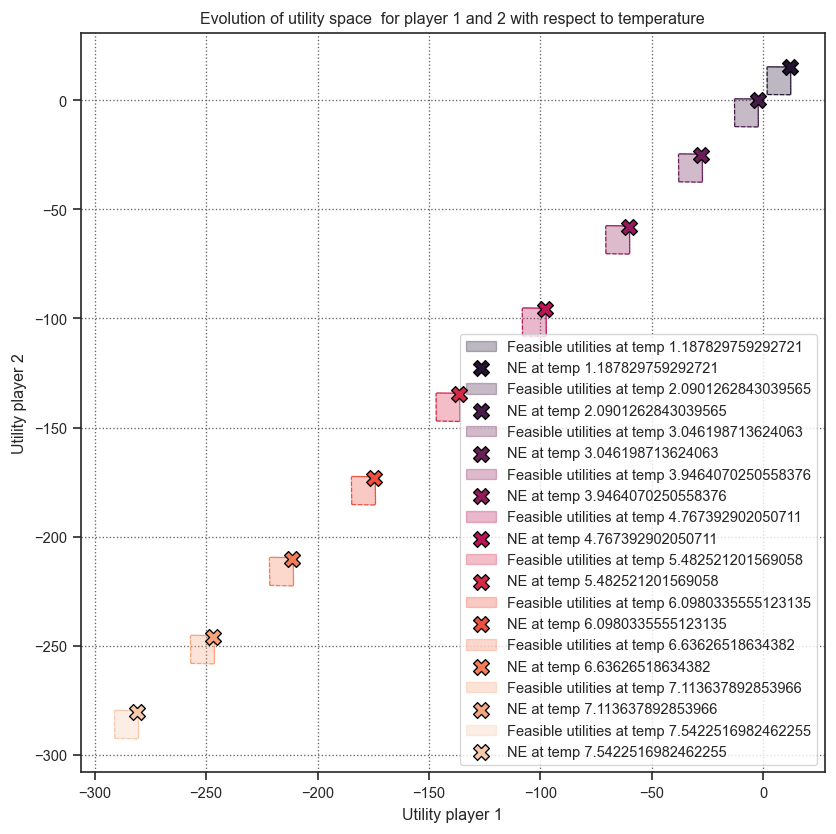

In [60]:
plot_utilities_merged_temp(strat_u,list_temp,pareto_at_u, ne_u)

In [ ]:
list_players = [player_class(name = 'player {}'.format(i), action_set = action_sets[i], smc = deepcopy(smc),
                                benefit_function = benefit_quadratic_concave_with_percentage_green(gdp_max[i], action_sets[i][1], percentage_green=0.2),
                                damage_function = damage_function,
                                impact_factor_of_temperature = deltas[i],
                                alpha=alpha) for i in range(N)]

game = Game(deepcopy(smc), list_players)

In [19]:
k = 10
percentage = np.arange(k+1)/k
tuple_percentage = [percentage * ub for ub in action_sets[:,1]]
product_strategy = np.array(list(product(*tuple_percentage)))
print(product_strategy[0])
product_strategy_sum = np.sum(product_strategy, axis=0)
print(product_strategy_sum.shape)


[0. 0. 0. 0. 0.]
(5,)


In [ ]:
product_strategy[0]

In [ ]:
product_strategy_sum

In [ ]:
smc.reset()
list_carbon = 851 *np.linspace(1, 30, 10)
list_temp = []
for carbon in list_carbon:
    smc.initialize_carbon_model(np.array([carbon, 460, 1740]))
    list_temp.append([smc.five_years_atmospheric_temp(x) for x in product_strategy_sum])


In [ ]:
list_carbon = 851 *np.linspace(1, 30, 10)
data_NE = []
for carbon in list_carbon:
    game = Game(deepcopy(smc), list_players)
    game.smc_game.initialize_carbon_model(np.array([carbon, 460, 1740]))
    for indice in range(game.N):
        player = list_players[indice]
        player.smc.initialize_smc(deepcopy(game.smc_game.carbon_state), deepcopy(game.smc_game.temperature_state), game.smc_game.num_cycle)
        
    
    data_NE.append(game.best_response_dynamic_one_shot(0))

data_NE = np.array(data_NE).T
data_NE_sum = np.sum(data_NE, axis=0)

for idx in range(N):
    player = list_players[idx]


In [ ]:
data_NE

In [ ]:
data_NE_sum

In [ ]:
variation_temp = np.linspace(smc.atmospheric_carbon, 5, 10)

data_utilities = []
list_utilities_profiles_NE = []
for temp in list_temp :
    utilities_product = np.zeros_like(product_strategy)
    for idx  in range(N):
        utilities_product[idx] = list_players[idx].utility_one_shot(product_strategy[idx], product_strategy_sum - product_strategy[idx], temp) 
    data_utilities.append(utilities_product)


In [ ]:
data_utilities =  np.moveaxis(np.array(data_utilities), [0,1,2],[2,1,0])
data_utilities.shape

In [ ]:
game = Game(deepcopy(smc), list_players)
game.smc_game.initialize_carbon_model
game.best_response_dynamic_one_shot()

In [ ]:
pareto_domiant_strict_utilities = []
pareto_domiant_delta_utilities = []
pareto_domiant_sum_utilities = []

pareto_domiant_strict_actions_profiles = []
pareto_domiant_delta_actions_profiles = []
pareto_domiant_sum_actions_profiles = []


for idx in range(len(data_utilities)):
    profile_strat_utilities = data_utilities[idx]
    if pareto_domine(utilities_NE, profile_strat_utilities):
        pareto_domiant_strict_utilities.append(profile_strat_utilities)
        pareto_domiant_strict_actions_profiles.append(data_actions_profiles[idx])

    if pareto_domine_over_delta(utilities_NE, profile_strat_utilities, delta=delta_step):
        pareto_domiant_delta_utilities.append(profile_strat_utilities)
        pareto_domiant_delta_actions_profiles.append(data_actions_profiles[idx])
    if pareto_domine_sum_utility(np.sum(utilities_NE,axis=1), np.sum(profile_strat_utilities,axis=1)):
        pareto_domiant_sum_utilities.append(profile_strat_utilities)
        pareto_domiant_delta_actions_profiles.append(data_actions_profiles[idx])

pareto_domiant_up = []
for time in range(T):
    pareto_domiant_up_time = []
    for idx in range(len(data_utilities)):
        profile_strat_utilities = data_utilities[idx]
        if pareto_domine_uptill_time(utilities_NE, profile_strat_utilities, time):
            pareto_domiant_up_time.append(profile_strat_utilities)

    pareto_domiant_up.append(pareto_domiant_up_time)

print('Num strat Pareto every step :', len(pareto_domiant_strict_utilities))
print('Num strat Pareto over {} steps :'.format(delta_step), len(pareto_domiant_delta_utilities))
print('Num strat Pareto in sum :', len(pareto_domiant_sum_utilities))

In [ ]:
colors = sns.color_palette("rocket",T//4+1)
plt.figure(figsize=(8,8),dpi=120)

c =0
for i in range(len(variation_temp)):
    points = np.array([list_utilities_profiles[i][indice_1], list_utilities_profiles[i][indice_2]]).T
    hull = ConvexHull(points)
    for simplex in hull.simplices:
        plt.plot(points[simplex, 0], points[simplex, 1],'--', c=colors[c], lw = .7)
    plt.fill(points[hull.vertices,0], points[hull.vertices,1], c=colors[c] , alpha=0.3)
    # plt.scatter(list_utilities_profiles[i][indice_1], list_utilities_profiles[i][indice_2], color= colors[c])
    c +=1
plt.show()

# Action identique tout au long du temps

## Damage Fixed

In [7]:
damage_coef = np.array([0,-7,7])
damage_function = damage_polynome(damage_coef)

## Benefit fixed Concave

In [8]:
list_benef_function = [benefit_quadratic_concave_with_percentage_green(gdp_max[i], action_sets[i,1], power=10) for i in range(N)]

In [9]:
list_players = [player_class(name = 'player {}'.format(i), action_set = action_sets[i], smc = deepcopy(smc),
                                benefit_function = list_benef_function[i],
                                damage_function = damage_function,
                                impact_factor_of_temperature = deltas[i],
                                alpha=alpha) for i in range(N)]

game = Game(deepcopy(smc), list_players)
game.repeated_one_shot_game()
utilities_NE = game.utilities_profiles
actions_NE = game.action_profiles

In [10]:
actions_NE

array([[9.74, 9.57, 9.43, 9.32, 9.22, 9.13, 9.06, 8.99, 8.93, 8.88, 8.84,
        8.8 , 8.77, 8.73, 8.71, 8.68, 8.66],
       [8.  , 8.  , 8.  , 8.  , 8.  , 8.  , 8.  , 8.  , 8.  , 8.  , 8.  ,
        8.  , 8.  , 8.  , 8.  , 8.  , 8.  ],
       [5.  , 5.  , 5.  , 5.  , 5.  , 5.  , 5.  , 5.  , 5.  , 5.  , 5.  ,
        5.  , 5.  , 5.  , 5.  , 5.  , 5.  ],
       [7.  , 7.  , 7.  , 7.  , 6.9 , 6.81, 6.74, 6.67, 6.61, 6.56, 6.52,
        6.48, 6.44, 6.41, 6.38, 6.35, 6.33],
       [9.  , 9.  , 9.  , 9.  , 9.  , 9.  , 9.  , 9.  , 9.  , 9.  , 9.  ,
        9.  , 9.  , 9.  , 9.  , 9.  , 9.  ]])

## Discretisation en 0\%, 50\% et 100\%

In [13]:
percentage = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])/10
tuple_percentage = [percentage * ub for ub in action_sets[:,1]]
product_strategy = product(*tuple_percentage)

list_product_strategy = np.array([list(x) for x in product_strategy], ndmin=3)
list_product_strategy_profile = np.moveaxis(np.moveaxis(np.repeat(list_product_strategy, repeats=T, axis=0), [0,1,2],[1,0,2]), [0,1,2], [0,2,1])
print(list_product_strategy_profile.shape)
data_utilities, data_actions_profiles = process(list_product_strategy_profile, smc, list_players)

(161051, 5, 17)


Processing: 100%|██████████| 161051/161051 [01:56<00:00, 1383.42it/s]


In [50]:
percentage = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])/10
tuple_percentage = [percentage * ub for ub in action_sets[:,1]]
product_strategy = product(*tuple_percentage)

list_product_strategy = np.array([list(x) for x in product_strategy], ndmin=3)
prod = np.moveaxis(np.moveaxis(np.repeat(list_product_strategy, repeats=T, axis=0), [0,1,2],[1,0,2]), [0,1,2], [0,2,1])

following_strat = []
for time in range(T):
    prod_copy = np.copy(prod)
    prod_copy[:,:,0:time] = np.repeat(np.array([actions_NE[:,0:time]]),repeats=prod_copy.shape[0], axis=0)
    following_strat.append(prod_copy)


len(following_strat)

17

In [51]:
following, following_action = process_following(following_strat,smc,list_players)

Processing: 100%|██████████| 161051/161051 [03:27<00:00, 777.20it/s]


In [125]:
x = np.array([[[0,0],
                [1,1]]])

In [126]:
np.repeat(x,repeats=2, axis=0)

array([[[0, 0],
        [1, 1]],

       [[0, 0],
        [1, 1]]])

In [130]:
np.array([actions_NE[:,0:3]])

array([[[9.74, 9.57, 9.44],
        [8.  , 8.  , 8.  ],
        [5.  , 5.  , 5.  ],
        [7.  , 7.  , 7.  ],
        [9.  , 9.  , 9.  ]]])

In [134]:
np.repeat(np.array([actions_NE[:,t]]),repeats=prod.shape[0], axis=0).shape

(7776, 5)

In [136]:
time = 5
prod = np.moveaxis(np.moveaxis(np.repeat(list_product_strategy, repeats=T, axis=0), [0,1,2],[1,0,2]), [0,1,2], [0,2,1])
for t in range(time):
    prod[:,:,t] = np.repeat(np.array([actions_NE[:,t]]),repeats=prod.shape[0], axis=0)
prod.shape

(7776, 5, 37)

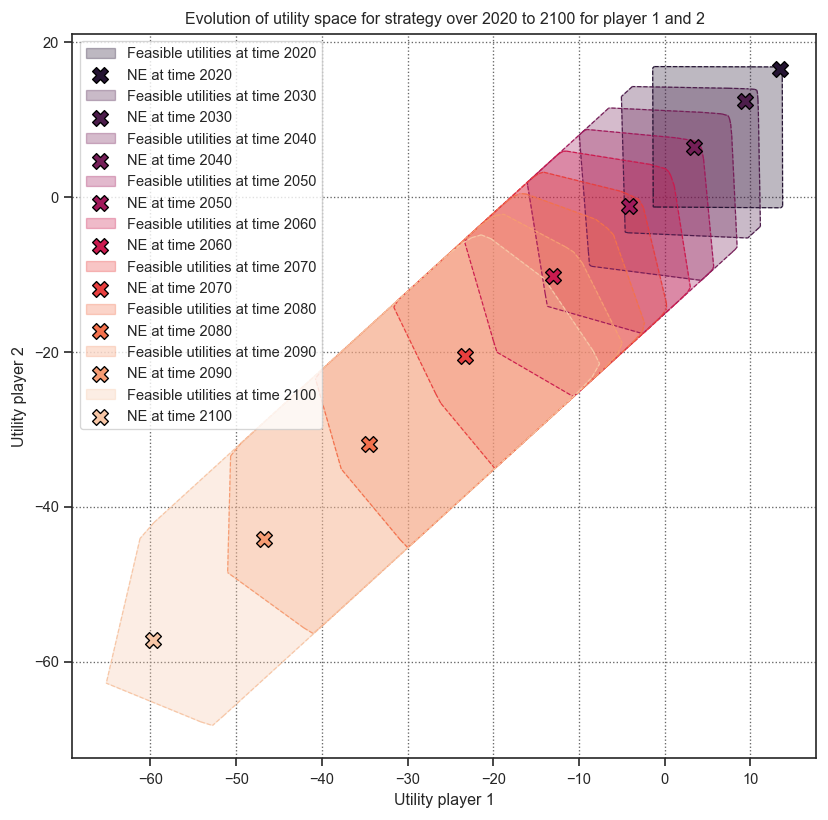

In [66]:
plot_utilities_merged(data_utilities, utilities_NE)

In [62]:
pareto_sum_a

[array([[0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
         0. , 0. , 0. , 0. ],
        [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
         0. , 0. , 0. , 0. ],
        [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
         0. , 0. , 0. , 0. ],
        [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
         0. , 0. , 0. , 0. ],
        [1.8, 1.8, 1.8, 1.8, 1.8, 1.8, 1.8, 1.8, 1.8, 1.8, 1.8, 1.8, 1.8,
         1.8, 1.8, 1.8, 1.8]]),
 array([[0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
         0. , 0. , 0. , 0. ],
        [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
         0. , 0. , 0. , 0. ],
        [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
         0. , 0. , 0. , 0. ],
        [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
         0. , 0. , 0. , 0. ],
        [2.7, 2.7, 2.7, 2.7, 2.7, 2.7, 2.7, 2.7, 2.7, 2.7, 2.7

Num strat Pareto every step : 0
Num strat Pareto in sum : 28677


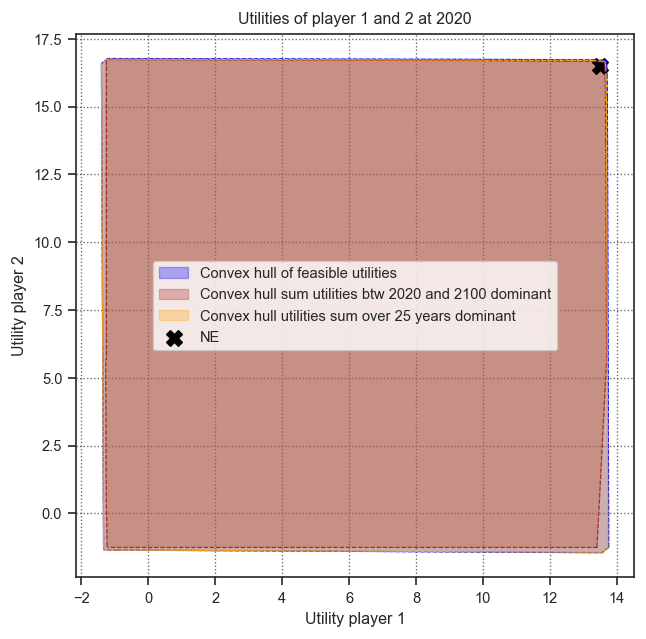

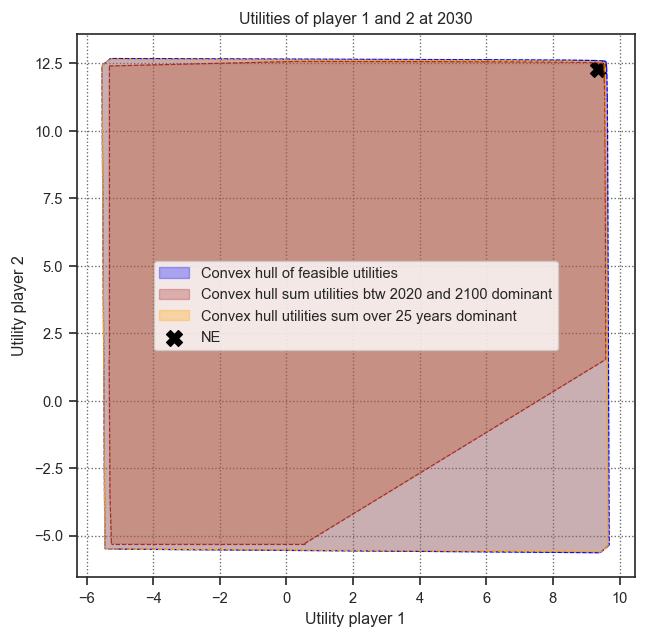

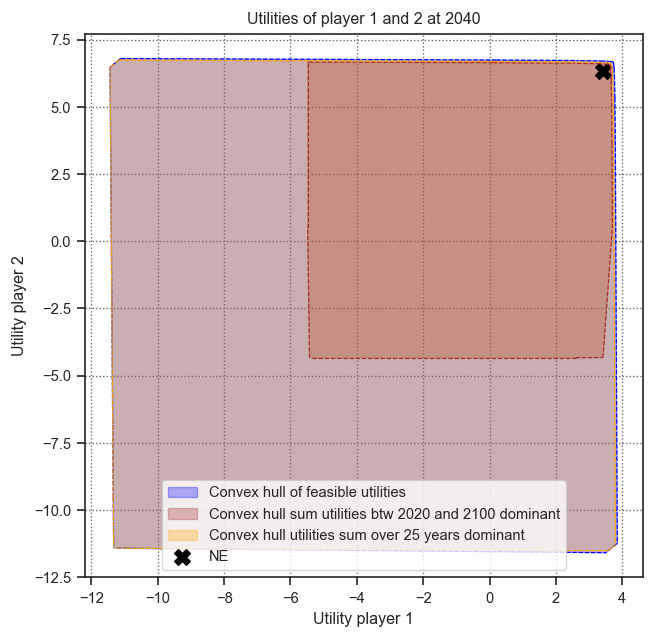

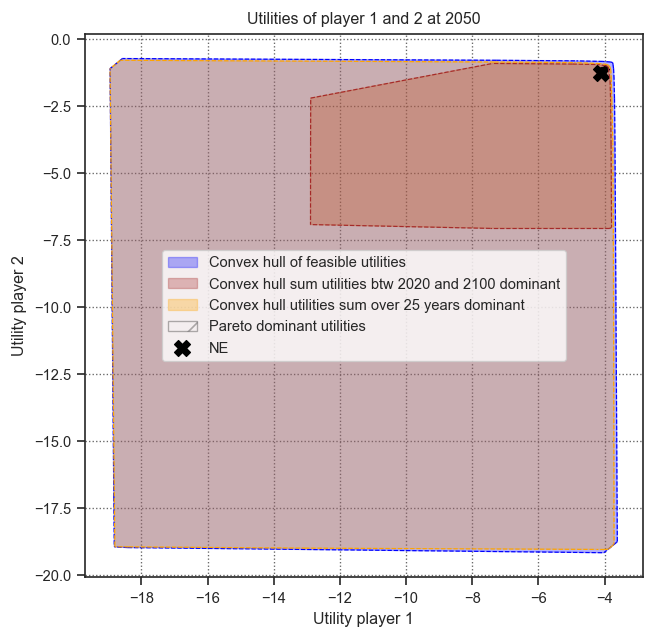

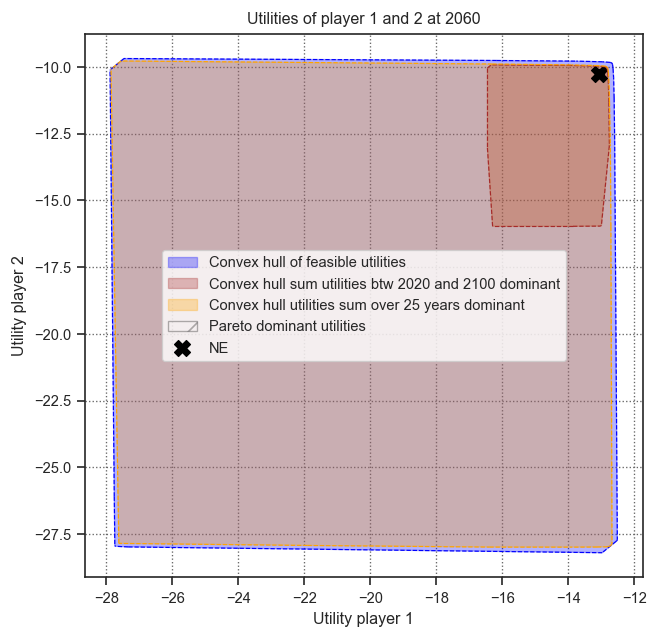

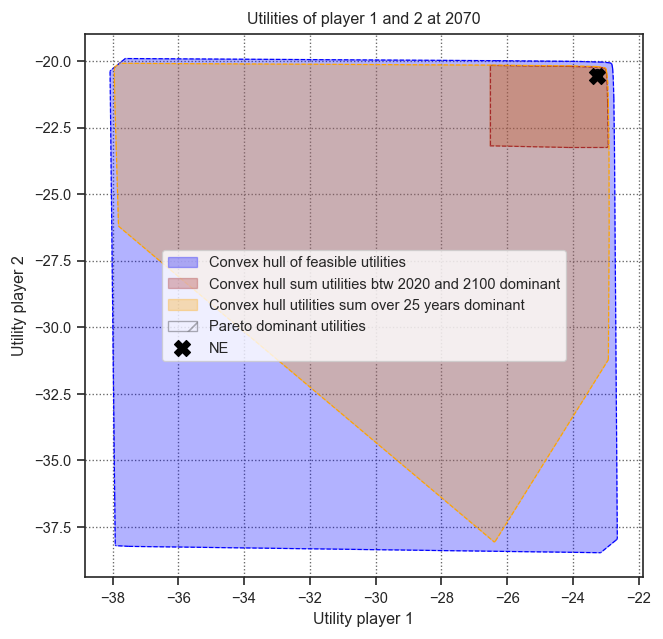

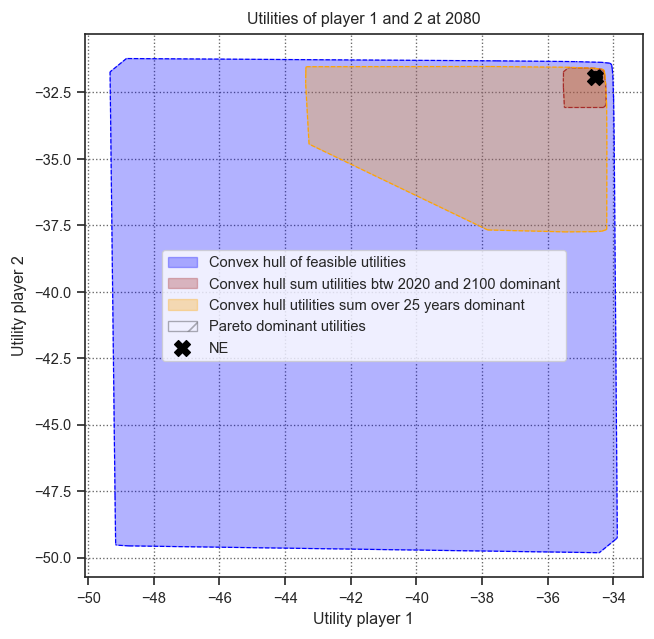

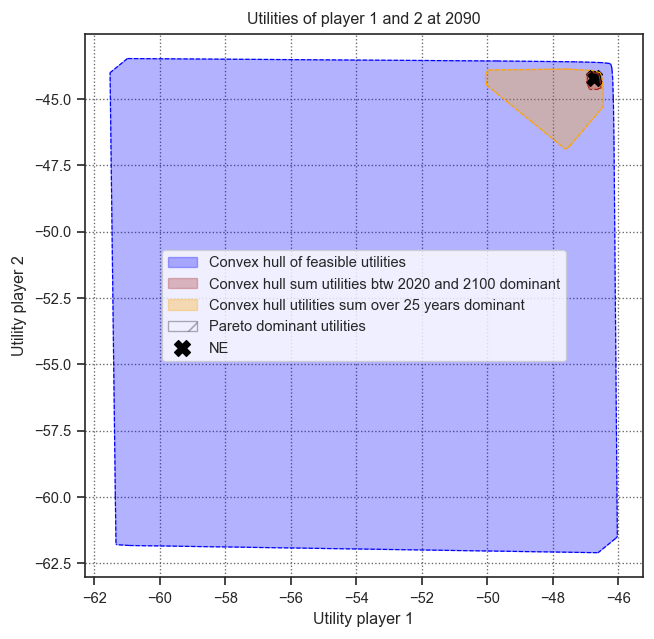

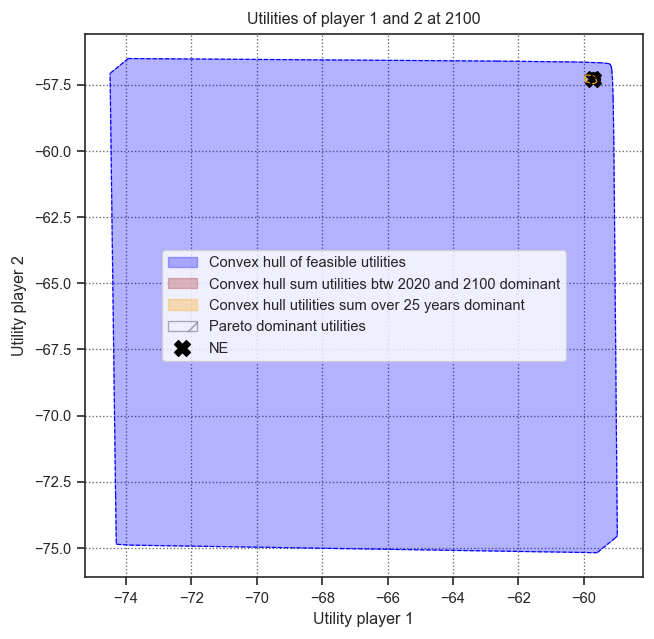

In [64]:
pareto_strict_u, pareto_strict_a, pareto_sum_u, pareto_sum_a = sort_data(data_utilities, data_actions_profiles, utilities_NE)
pareto_at_u, pareto_at_a, pareto_delta_u, pareto_delta_a, pareto_sum_u, pareto_sum_a  = sort_follow(following,following_action, utilities_NE)


C:\Users\anthony.couthures\AppData\Local\Temp\ipykernel_24996\3756230405.py:91: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(utilities_NE[indice_1,time], utilities_NE[indice_2,time], label ='NE', marker='+',s=10,c='black', edgecolor='black')


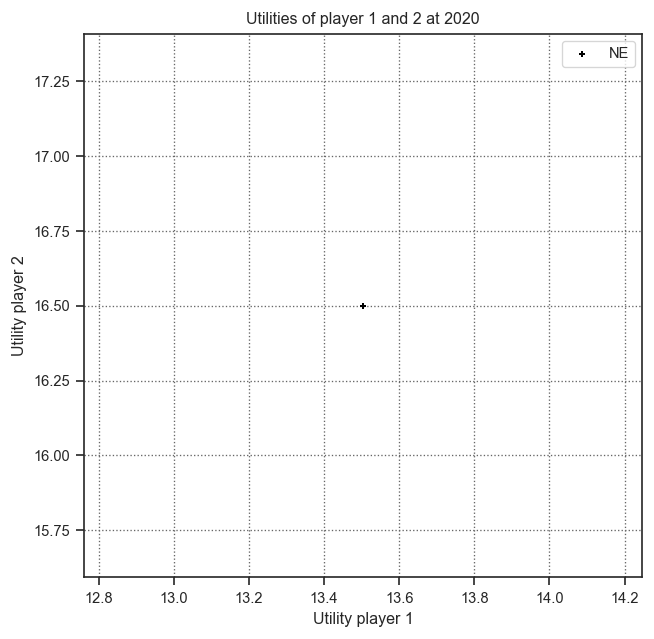

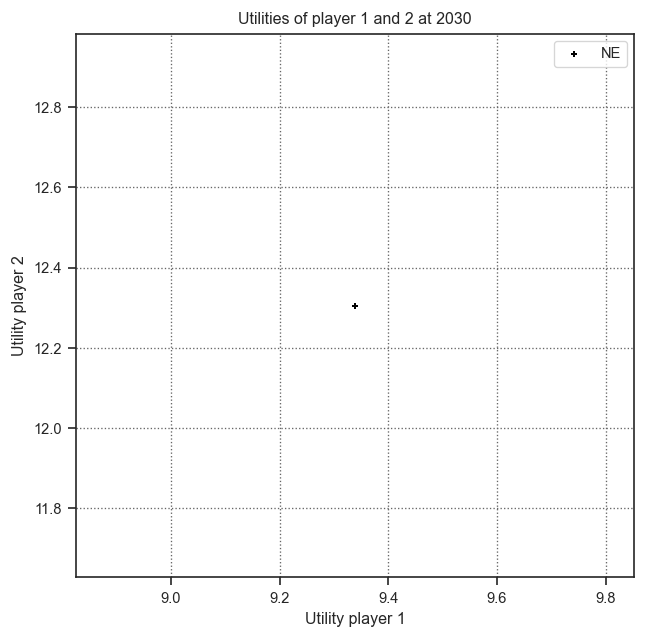

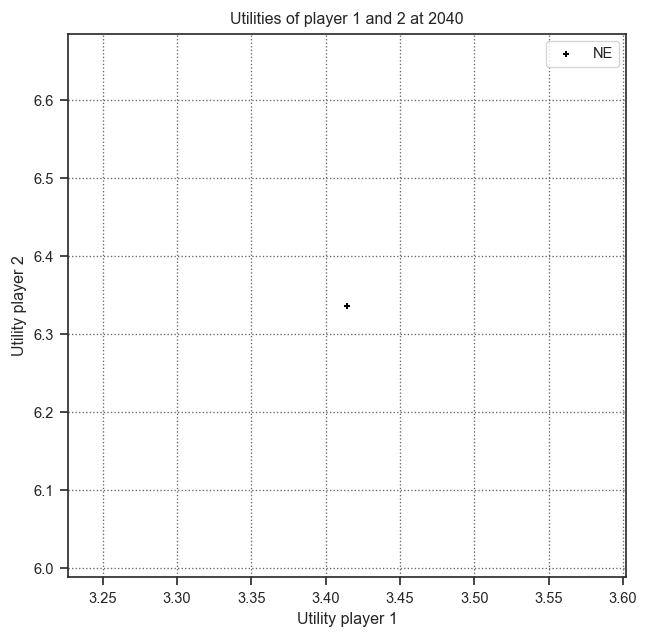

C:\Users\anthony.couthures\AppData\Local\Temp\ipykernel_24996\3756230405.py:91: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(utilities_NE[indice_1,time], utilities_NE[indice_2,time], label ='NE', marker='+',s=10,c='black', edgecolor='black')


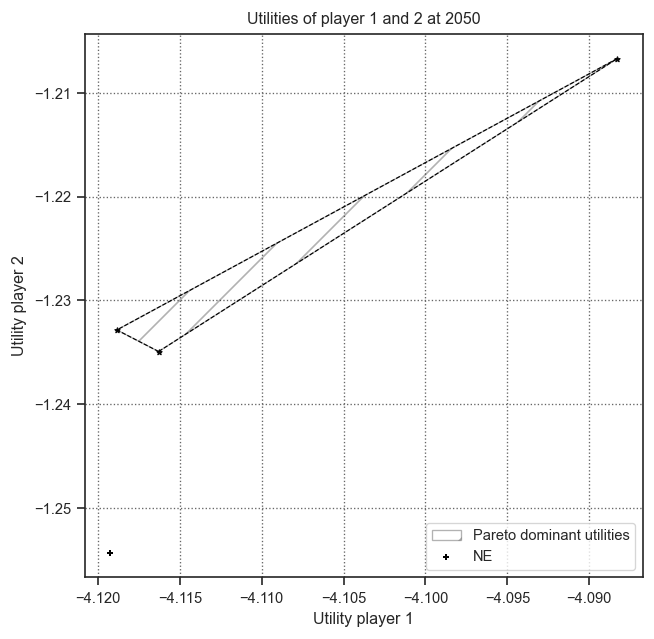

C:\Users\anthony.couthures\AppData\Local\Temp\ipykernel_24996\3756230405.py:91: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(utilities_NE[indice_1,time], utilities_NE[indice_2,time], label ='NE', marker='+',s=10,c='black', edgecolor='black')


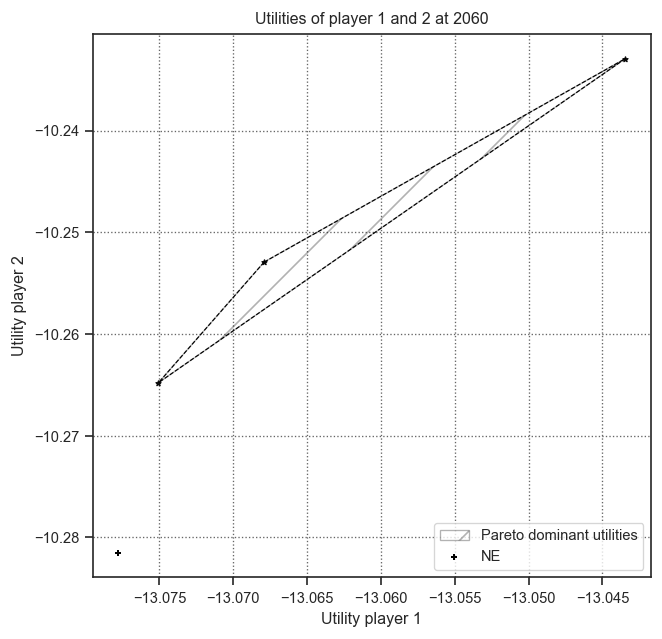

C:\Users\anthony.couthures\AppData\Local\Temp\ipykernel_24996\3756230405.py:91: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(utilities_NE[indice_1,time], utilities_NE[indice_2,time], label ='NE', marker='+',s=10,c='black', edgecolor='black')


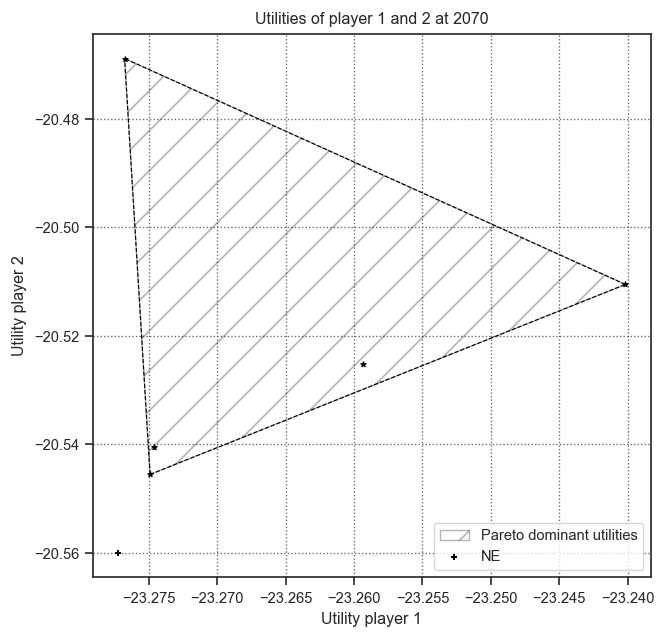

C:\Users\anthony.couthures\AppData\Local\Temp\ipykernel_24996\3756230405.py:91: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(utilities_NE[indice_1,time], utilities_NE[indice_2,time], label ='NE', marker='+',s=10,c='black', edgecolor='black')


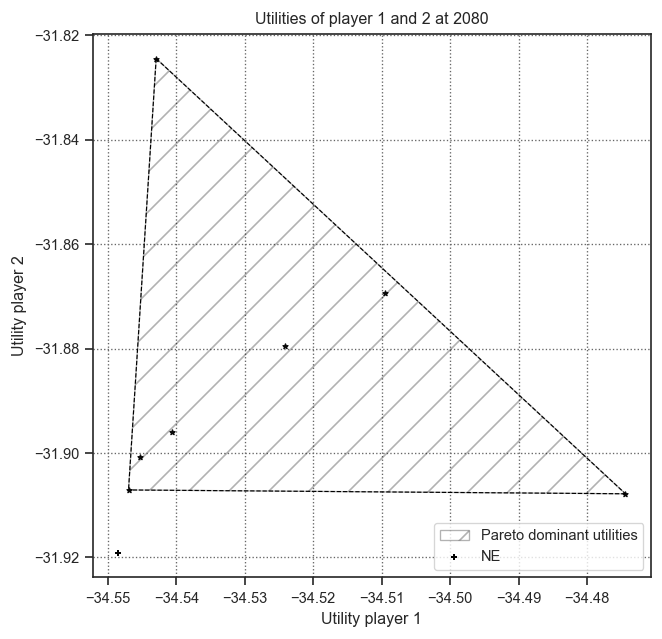

C:\Users\anthony.couthures\AppData\Local\Temp\ipykernel_24996\3756230405.py:91: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(utilities_NE[indice_1,time], utilities_NE[indice_2,time], label ='NE', marker='+',s=10,c='black', edgecolor='black')


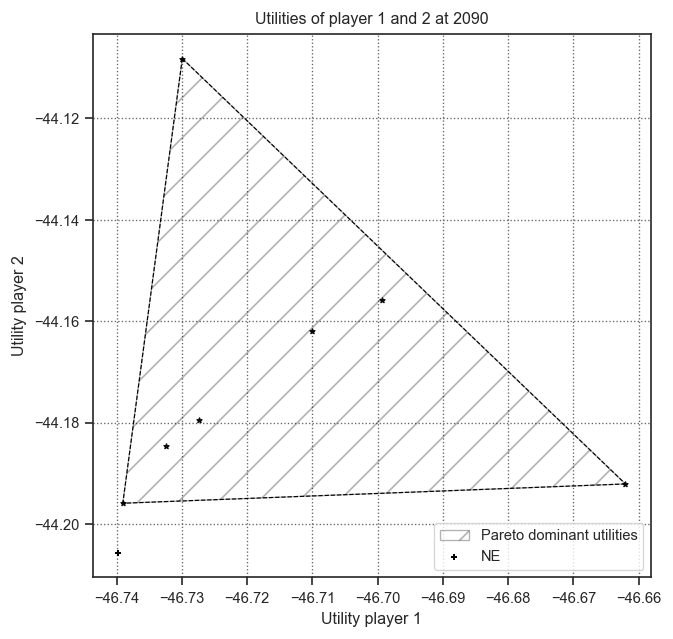

C:\Users\anthony.couthures\AppData\Local\Temp\ipykernel_24996\3756230405.py:91: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(utilities_NE[indice_1,time], utilities_NE[indice_2,time], label ='NE', marker='+',s=10,c='black', edgecolor='black')


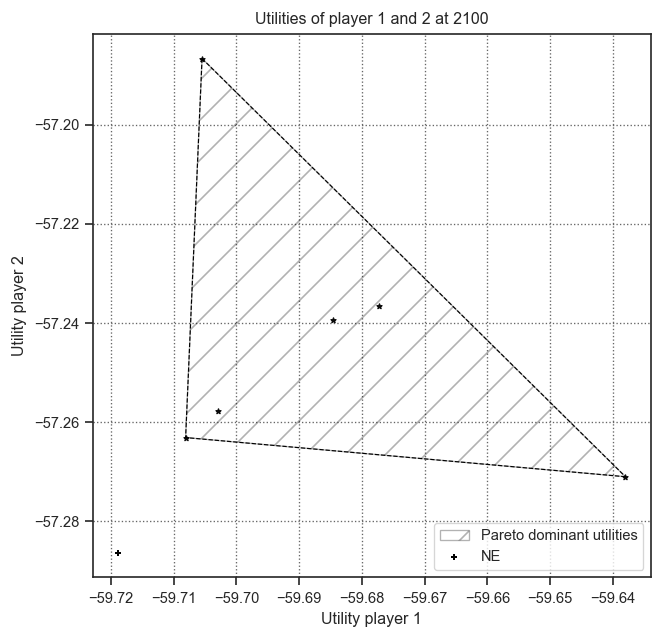

In [73]:
plot_utilities_space(0, utilities_NE, 0, 0, pareto_strict_u, pareto_at_u)

In [40]:
pareto_at

[[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []]

## Discretisation en 0\%, 50\% et 100\%

In [ ]:
percentage = np.array([0, 2, 4, 6, 8, 10])/10

tuple_percentage = [percentage * ub for ub in action_sets[:,1]]
product_strategy = product(*tuple_percentage)

list_product_strategy = np.array([list(x) for x in product_strategy], ndmin=3)
list_product_strategy_profile = np.moveaxis(np.moveaxis(np.repeat(list_product_strategy, repeats=T, axis=0), [0,1,2],[1,0,2]), [0,1,2], [0,2,1])
print(list_product_strategy_profile.shape)
data_utilities, data_actions_profiles = process(list_product_strategy_profile, smc, list_players)

In [ ]:
plt.figure(figsize=(8,8),dpi=120)
colors = sns.color_palette("rocket",T//4+1)
c = 0
for time in range(0,T, 4):
    scatter_indice_1 = [profile[indice_1,time] for profile in data_utilities]
    scatter_indice_2 = [profile[indice_2,time] for profile in data_utilities]
    points = np.array([scatter_indice_1,scatter_indice_2]).T
    hull = ConvexHull(points)
    for simplex in hull.simplices:
        plt.plot(points[simplex, 0], points[simplex, 1],'--', c=colors[c], lw = .7)
    plt.fill(points[hull.vertices,0], points[hull.vertices,1], c=colors[c] , alpha=0.3)

    # plt.scatter(scatter_indice_1,scatter_indice_2, alpha=0.4)
    c += 1

plt.gca().set_prop_cycle(None)
c = 0

for time in range(0,T, 4):

    plt.scatter(utilities_NE[indice_1,time], utilities_NE[indice_2,time], color=colors[c], label ='NE', marker='X',s=90, edgecolor='black')
    c += 1

plt.legend()
plt.show()

In [ ]:
pareto_domiant_strict_utilities = []
pareto_domiant_delta_utilities = []
pareto_domiant_sum_utilities = []

pareto_domiant_strict_actions_profiles = []
pareto_domiant_delta_actions_profiles = []
pareto_domiant_sum_actions_profiles = []


for idx in range(len(data_utilities)):
    profile_strat_utilities = data_utilities[idx]
    if pareto_domine_over_time(utilities_NE, profile_strat_utilities):
        pareto_domiant_strict_utilities.append(profile_strat_utilities)
        pareto_domiant_strict_actions_profiles.append(data_actions_profiles[idx])

    if pareto_domine_over_delta(utilities_NE, profile_strat_utilities, delta=delta_step):
        pareto_domiant_delta_utilities.append(profile_strat_utilities)
        pareto_domiant_delta_actions_profiles.append(data_actions_profiles[idx])
    if pareto_domine_sum_utility(np.sum(utilities_NE,axis=1), np.sum(profile_strat_utilities,axis=1)):
        pareto_domiant_sum_utilities.append(profile_strat_utilities)
        pareto_domiant_delta_actions_profiles.append(data_actions_profiles[idx])

print('Num strat Pareto every step :', len(pareto_domiant_strict_utilities))
print('Num strat Pareto over {} steps :'.format(delta_step), len(pareto_domiant_delta_utilities))
print('Num strat Pareto in sum :', len(pareto_domiant_sum_utilities))

In [ ]:


colors = sns.color_palette("tab10")
for time in range(0,T, 4):
    plt.figure(figsize=(6,6),dpi=120)
    scatter_indice_1 = [profile[indice_1,time] for profile in data_utilities]
    scatter_indice_2 = [profile[indice_2,time] for profile in data_utilities]
    plt.scatter(scatter_indice_1,scatter_indice_2,c='b', alpha=0.9)

    points = np.array([scatter_indice_1,scatter_indice_2]).T
    hull = ConvexHull(points)
    for simplex in hull.simplices:
        plt.plot(points[simplex, 0], points[simplex, 1],'--', c='b', lw = .7)
    plt.fill(points[hull.vertices,0], points[hull.vertices,1], 'b', alpha=0.3,label ='convex hull utilities')


    scatter_indice_1 = [profile[indice_1,time] for profile in pareto_domiant_delta_utilities]
    scatter_indice_2 = [profile[indice_2,time] for profile in pareto_domiant_delta_utilities]
    points = np.array([scatter_indice_1,scatter_indice_2]).T
    hull = ConvexHull(points)
    for simplex in hull.simplices:
        plt.plot(points[simplex, 0], points[simplex, 1],'--', c='orange', lw = .7)
    plt.fill(points[hull.vertices,0], points[hull.vertices,1], 'orange', alpha=0.3,label ='convex hull sum over {} step dominant'.format(delta_step))
    plt.scatter(scatter_indice_1,scatter_indice_2,c='orange', alpha=0.9)
    
    scatter_indice_1 = [profile[indice_1,time] for profile in pareto_domiant_sum_utilities]
    scatter_indice_2 = [profile[indice_2,time] for profile in pareto_domiant_sum_utilities]
    points = np.array([scatter_indice_1,scatter_indice_2]).T
    hull = ConvexHull(points)
    for simplex in hull.simplices:
        plt.plot(points[simplex, 0], points[simplex, 1],'--', c='brown', lw = .7)
    plt.fill(points[hull.vertices,0], points[hull.vertices,1], 'brown', alpha=0.3,label ='convex hull sum dominant')
    plt.scatter(scatter_indice_1,scatter_indice_2,c='brown', alpha=0.9)
    c += 1

    try :
        scatter_indice_1 = [profile[indice_1,time] for profile in pareto_domiant_sum_utilities]
        scatter_indice_2 = [profile[indice_2,time] for profile in pareto_domiant_sum_utilities]
        points = np.array([scatter_indice_1,scatter_indice_2]).T
        hull = ConvexHull(points)
        for simplex in hull.simplices:
            plt.plot(points[simplex, 0], points[simplex, 1],'--', c='brown', lw = .7)
        plt.fill(points[hull.vertices,0], points[hull.vertices,1], 'brown', alpha=0.3,label ='convex hull sum dominant')
        plt.scatter(scatter_indice_1,scatter_indice_2,c='brown', alpha=0.9)
        c += 1
    except:
        pass

    plt.scatter(utilities_NE[indice_1,time], utilities_NE[indice_2,time], label ='NE', marker='X',s=90,c='black', edgecolor='black')
    plt.legend()
    plt.show()


## Discretisation en 0\%, 50\% et 100\%

In [ ]:
percentage = np.array([0, 1, 2, 3,  4, 5,  6, 7,  8, 9, 10])/10
tuple_percentage = [percentage * ub for ub in action_sets[:,1]]
product_strategy = product(*tuple_percentage)

list_product_strategy = np.array([list(x) for x in product_strategy], ndmin=3)
list_product_strategy_profile = np.moveaxis(np.moveaxis(np.repeat(list_product_strategy, repeats=T, axis=0), [0,1,2],[1,0,2]), [0,1,2], [0,2,1])
print(list_product_strategy_profile.shape)
data_utilities, data_actions_profiles = process(list_product_strategy_profile, smc, list_players)

In [ ]:
plt.figure(figsize=(8,8),dpi=120)
colors = sns.color_palette("rocket",T//4+1)
c = 0
for time in range(0,T, 4):
    scatter_indice_1 = [profile[indice_1,time] for profile in data_utilities]
    scatter_indice_2 = [profile[indice_2,time] for profile in data_utilities]
    points = np.array([scatter_indice_1,scatter_indice_2]).T
    hull = ConvexHull(points)
    for simplex in hull.simplices:
        plt.plot(points[simplex, 0], points[simplex, 1],'--', c=colors[c], lw = .7)
    plt.fill(points[hull.vertices,0], points[hull.vertices,1], c=colors[c] , alpha=0.3)

    # plt.scatter(scatter_indice_1,scatter_indice_2, alpha=0.4)
    c += 1

plt.gca().set_prop_cycle(None)
c = 0

for time in range(0,T, 4):

    plt.scatter(utilities_NE[indice_1,time], utilities_NE[indice_2,time], color=colors[c], label ='NE', marker='X',s=90, edgecolor='black')
    c += 1

plt.legend()
plt.show()

# Action randomized

In [ ]:
k = 10
num_sample = 100000

In [ ]:
percentage

In [ ]:
percentage = np.arange(k+1)/k
tuple_percentage = [percentage * ub for ub in action_sets[:,1]]
product_strategy = product(*tuple_percentage)
list_product_strategy = [list(x) for x in product_strategy]
random_product = []
for k in tqdm(range(num_sample), desc='Sampling'):
    random_product.append(random.choices(list_product_strategy, k= T))
random_product = np.array(random_product)
list_product_strategy_profile = np.moveaxis(random_product, [0,1,2], [0,2,1])
print(list_product_strategy_profile.shape)
data_utilities, data_actions_profiles = process(list_product_strategy_profile, smc, list_players)

In [ ]:
plt.figure(figsize=(8,8),dpi=120)
colors = sns.color_palette("rocket",T//4+1)
c = 0
for time in range(0,T, 4):
    scatter_indice_1 = [profile[indice_1,time] for profile in data_utilities]
    scatter_indice_2 = [profile[indice_2,time] for profile in data_utilities]
    points = np.array([scatter_indice_1,scatter_indice_2]).T
    hull = ConvexHull(points)
    for simplex in hull.simplices:
        plt.plot(points[simplex, 0], points[simplex, 1],'--', c=colors[c], lw = .7)
    plt.fill(points[hull.vertices,0], points[hull.vertices,1], c=colors[c] , alpha=0.3)

    # plt.scatter(scatter_indice_1,scatter_indice_2, alpha=0.4)
    c += 1

plt.gca().set_prop_cycle(None)
c = 0

for time in range(0,T, 4):

    plt.scatter(utilities_NE[indice_1,time], utilities_NE[indice_2,time], color=colors[c], label ='NE', marker='X',s=90, edgecolor='black')
    c += 1

plt.legend()
plt.show()

In [ ]:
pareto_domiant_strict_utilities = []
pareto_domiant_delta_utilities = []
pareto_domiant_sum_utilities = []

pareto_domiant_strict_actions_profiles = []
pareto_domiant_delta_actions_profiles = []
pareto_domiant_sum_actions_profiles = []


for idx in range(len(data_utilities)):
    profile_strat_utilities = data_utilities[idx]
    if pareto_domine_over_time(utilities_NE, profile_strat_utilities):
        pareto_domiant_strict_utilities.append(profile_strat_utilities)
        pareto_domiant_strict_actions_profiles.append(data_actions_profiles[idx])

    if pareto_domine_over_delta(utilities_NE, profile_strat_utilities, delta=delta_step):
        pareto_domiant_delta_utilities.append(profile_strat_utilities)
        pareto_domiant_delta_actions_profiles.append(data_actions_profiles[idx])
    if pareto_domine_sum_utility(np.sum(utilities_NE,axis=1), np.sum(profile_strat_utilities,axis=1)):
        pareto_domiant_sum_utilities.append(profile_strat_utilities)
        pareto_domiant_delta_actions_profiles.append(data_actions_profiles[idx])

print('Num strat Pareto every step :', len(pareto_domiant_strict_utilities))
print('Num strat Pareto over {} steps :'.format(delta_step), len(pareto_domiant_delta_utilities))
print('Num strat Pareto in sum :', len(pareto_domiant_sum_utilities))

In [ ]:


colors = sns.color_palette("tab10")
for time in range(0,T, 4):
    plt.figure(figsize=(6,6),dpi=120)
    scatter_indice_1 = [profile[indice_1,time] for profile in data_utilities]
    scatter_indice_2 = [profile[indice_2,time] for profile in data_utilities]
    plt.scatter(scatter_indice_1,scatter_indice_2,c='b', alpha=0.1)

    points = np.array([scatter_indice_1,scatter_indice_2]).T
    hull = ConvexHull(points)
    for simplex in hull.simplices:
        plt.plot(points[simplex, 0], points[simplex, 1],'--', c='b', lw = .7)
    plt.fill(points[hull.vertices,0], points[hull.vertices,1], 'b', alpha=0.3,label ='convex hull utilities')


    scatter_indice_1 = [profile[indice_1,time] for profile in pareto_domiant_delta_utilities]
    scatter_indice_2 = [profile[indice_2,time] for profile in pareto_domiant_delta_utilities]
    points = np.array([scatter_indice_1,scatter_indice_2]).T
    hull = ConvexHull(points)
    for simplex in hull.simplices:
        plt.plot(points[simplex, 0], points[simplex, 1],'--', c='orange', lw = .7)
    plt.fill(points[hull.vertices,0], points[hull.vertices,1], 'orange', alpha=0.3,label ='convex hull sum over {} step dominant'.format(delta_step))
    plt.scatter(scatter_indice_1,scatter_indice_2,c='orange', alpha=0.1)
    
    scatter_indice_1 = [profile[indice_1,time] for profile in pareto_domiant_sum_utilities]
    scatter_indice_2 = [profile[indice_2,time] for profile in pareto_domiant_sum_utilities]
    points = np.array([scatter_indice_1,scatter_indice_2]).T
    hull = ConvexHull(points)
    for simplex in hull.simplices:
        plt.plot(points[simplex, 0], points[simplex, 1],'--', c='brown', lw = .7)
    plt.fill(points[hull.vertices,0], points[hull.vertices,1], 'brown', alpha=0.3,label ='convex hull sum dominant')
    plt.scatter(scatter_indice_1,scatter_indice_2,c='brown', alpha=0.1)
    c += 1

    try :
        scatter_indice_1 = [profile[indice_1,time] for profile in pareto_domiant_strict_utilities]
        scatter_indice_2 = [profile[indice_2,time] for profile in pareto_domiant_strict_utilities]
        points = np.array([scatter_indice_1,scatter_indice_2]).T
        hull = ConvexHull(points)
        for simplex in hull.simplices:
            plt.plot(points[simplex, 0], points[simplex, 1],'--', c='brown', lw = .7)
        plt.fill(points[hull.vertices,0], points[hull.vertices,1], 'brown', alpha=0.3,label ='convex hull sum dominant')
        plt.scatter(scatter_indice_1,scatter_indice_2,c='brown', alpha=0.1)
        c += 1
    except:
        pass

    plt.scatter(utilities_NE[indice_1,time], utilities_NE[indice_2,time], label ='NE', marker='X',s=90,c='black', edgecolor='black')
    plt.legend()
    plt.show()


In [ ]:


plt.figure(figsize=(8,8),dpi=120)
colors = sns.color_palette("rocket",T//4+1)
c = 0
for time in range(0,T, 4):
    scatter_indice_1 = [profile[indice_1,time] for profile in data_utilities]
    scatter_indice_2 = [profile[indice_2,time] for profile in data_utilities]
    plt.scatter(scatter_indice_1,scatter_indice_2, alpha=0.4)

    scatter_indice_1 = [profile[indice_1,time] for profile in pareto_domiant_delta_utilities]
    scatter_indice_2 = [profile[indice_2,time] for profile in pareto_domiant_delta_utilities]
    points = np.array([scatter_indice_1,scatter_indice_2]).T
    hull = ConvexHull(points)
    for simplex in hull.simplices:
        plt.plot(points[simplex, 0], points[simplex, 1],'--', c=colors[c], lw = .7)
    plt.scatter(scatter_indice_1,scatter_indice_2, alpha=0.4)
    c += 1

plt.gca().set_prop_cycle(None)
for time in range(0,T, 4):

    plt.scatter(utilities_NE[indice_1,time], utilities_NE[indice_2,time], label ='NE', marker='X',s=90, edgecolor='black')
plt.legend()
plt.show()


## Benefit fixed Convexe

In [ ]:
list_benef_function = [benefit_quadratic_convex_with_percentage_green(gdp_max[i], action_sets[i,1], percentage_green=0.3) for i in range(N)]

In [ ]:
list_players = [player_class(name = 'player {}'.format(i), action_set = action_sets[i], smc = deepcopy(smc),
                                benefit_function = benefit_quadratic_concave_with_percentage_green(gdp_max[i], action_sets[i][1], percentage_green=0.2),
                                damage_function = damage_function,
                                impact_factor_of_temperature = deltas[i],
                                alpha=alpha) for i in range(N)]

game = Game(deepcopy(smc), list_players)
game.repeated_one_shot_game()
utilities_NE = game.utilities_profiles
actions_NE = game.action_profiles

## Discretisation en 0\%, 50\% et 100\%

In [ ]:
percentage = np.array([0, 5, 10])/10
tuple_percentage = [percentage * ub for ub in action_sets[:,1]]
product_strategy = product(*tuple_percentage)

list_product_strategy = np.array([list(x) for x in product_strategy], ndmin=3)
list_product_strategy_profile = np.moveaxis(np.moveaxis(np.repeat(list_product_strategy, repeats=T, axis=0), [0,1,2],[1,0,2]), [0,1,2], [0,2,1])
print(list_product_strategy_profile.shape)
data_utilities, data_actions_profiles = process(list_product_strategy_profile, smc, list_players)

In [ ]:
plt.figure(figsize=(8,8),dpi=120)
colors = sns.color_palette("rocket",T//4+1)
c = 0
for time in range(0,T, 4):
    scatter_indice_1 = [profile[indice_1,time] for profile in data_utilities]
    scatter_indice_2 = [profile[indice_2,time] for profile in data_utilities]
    points = np.array([scatter_indice_1,scatter_indice_2]).T
    hull = ConvexHull(points)
    for simplex in hull.simplices:
        plt.plot(points[simplex, 0], points[simplex, 1],'--', c=colors[c], lw = .7)
    plt.fill(points[hull.vertices,0], points[hull.vertices,1], c=colors[c] , alpha=0.3)

    # plt.scatter(scatter_indice_1,scatter_indice_2, alpha=0.4)
    c += 1

plt.gca().set_prop_cycle(None)
c = 0

for time in range(0,T, 4):

    plt.scatter(utilities_NE[indice_1,time], utilities_NE[indice_2,time], color=colors[c], label ='NE', marker='X',s=90, edgecolor='black')
    c += 1

plt.legend()
plt.show()

In [ ]:
pareto_domiant_strict_utilities = []
pareto_domiant_delta_utilities = []
pareto_domiant_sum_utilities = []

pareto_domiant_strict_actions_profiles = []
pareto_domiant_delta_actions_profiles = []
pareto_domiant_sum_actions_profiles = []


for idx in range(len(data_utilities)):
    profile_strat_utilities = data_utilities[idx]
    if pareto_domine_over_time(utilities_NE, profile_strat_utilities):
        pareto_domiant_strict_utilities.append(profile_strat_utilities)
        pareto_domiant_strict_actions_profiles.append(data_actions_profiles[idx])

    if pareto_domine_over_delta(utilities_NE, profile_strat_utilities, delta=delta_step):
        pareto_domiant_delta_utilities.append(profile_strat_utilities)
        pareto_domiant_delta_actions_profiles.append(data_actions_profiles[idx])
    if pareto_domine_sum_utility(np.sum(utilities_NE,axis=1), np.sum(profile_strat_utilities,axis=1)):
        pareto_domiant_sum_utilities.append(profile_strat_utilities)
        pareto_domiant_delta_actions_profiles.append(data_actions_profiles[idx])

print('Num strat Pareto every step :', len(pareto_domiant_strict_utilities))
print('Num strat Pareto over {} steps :'.format(delta_step), len(pareto_domiant_delta_utilities))
print('Num strat Pareto in sum :', len(pareto_domiant_sum_utilities))

In [ ]:


colors = sns.color_palette("tab10")
for time in range(0,T, 4):
    plt.figure(figsize=(6,6),dpi=120)
    scatter_indice_1 = [profile[indice_1,time] for profile in data_utilities]
    scatter_indice_2 = [profile[indice_2,time] for profile in data_utilities]
    plt.scatter(scatter_indice_1,scatter_indice_2,c='b', alpha=0.9)

    points = np.array([scatter_indice_1,scatter_indice_2]).T
    hull = ConvexHull(points)
    for simplex in hull.simplices:
        plt.plot(points[simplex, 0], points[simplex, 1],'--', c='b', lw = .7)
    plt.fill(points[hull.vertices,0], points[hull.vertices,1], 'b', alpha=0.3,label ='convex hull utilities')


    scatter_indice_1 = [profile[indice_1,time] for profile in pareto_domiant_delta_utilities]
    scatter_indice_2 = [profile[indice_2,time] for profile in pareto_domiant_delta_utilities]
    points = np.array([scatter_indice_1,scatter_indice_2]).T
    hull = ConvexHull(points)
    for simplex in hull.simplices:
        plt.plot(points[simplex, 0], points[simplex, 1],'--', c='orange', lw = .7)
    plt.fill(points[hull.vertices,0], points[hull.vertices,1], 'orange', alpha=0.3,label ='convex hull sum over {} step dominant'.format(delta_step))
    plt.scatter(scatter_indice_1,scatter_indice_2,c='orange', alpha=0.9)
    
    scatter_indice_1 = [profile[indice_1,time] for profile in pareto_domiant_sum_utilities]
    scatter_indice_2 = [profile[indice_2,time] for profile in pareto_domiant_sum_utilities]
    points = np.array([scatter_indice_1,scatter_indice_2]).T
    hull = ConvexHull(points)
    for simplex in hull.simplices:
        plt.plot(points[simplex, 0], points[simplex, 1],'--', c='brown', lw = .7)
    plt.fill(points[hull.vertices,0], points[hull.vertices,1], 'brown', alpha=0.3,label ='convex hull sum dominant')
    plt.scatter(scatter_indice_1,scatter_indice_2,c='brown', alpha=0.9)
    c += 1

    try :
        scatter_indice_1 = [profile[indice_1,time] for profile in pareto_domiant_sum_utilities]
        scatter_indice_2 = [profile[indice_2,time] for profile in pareto_domiant_sum_utilities]
        points = np.array([scatter_indice_1,scatter_indice_2]).T
        hull = ConvexHull(points)
        for simplex in hull.simplices:
            plt.plot(points[simplex, 0], points[simplex, 1],'--', c='brown', lw = .7)
        plt.fill(points[hull.vertices,0], points[hull.vertices,1], 'brown', alpha=0.3,label ='convex hull sum dominant')
        plt.scatter(scatter_indice_1,scatter_indice_2,c='brown', alpha=0.9)
        c += 1
    except:
        pass

    plt.scatter(utilities_NE[indice_1,time], utilities_NE[indice_2,time], label ='NE', marker='X',s=90,c='black', edgecolor='black')
    plt.legend()
    plt.show()


## Discretisation en 0\%, 50\% et 100\%

In [ ]:
percentage = np.array([0, 2, 4, 6, 8, 10])/10

tuple_percentage = [percentage * ub for ub in action_sets[:,1]]
product_strategy = product(*tuple_percentage)

list_product_strategy = np.array([list(x) for x in product_strategy], ndmin=3)
list_product_strategy_profile = np.moveaxis(np.moveaxis(np.repeat(list_product_strategy, repeats=T, axis=0), [0,1,2],[1,0,2]), [0,1,2], [0,2,1])
print(list_product_strategy_profile.shape)
data_utilities, data_actions_profiles = process(list_product_strategy_profile, smc, list_players)

In [ ]:
plt.figure(figsize=(8,8),dpi=120)
colors = sns.color_palette("rocket",T//4+1)
c = 0
for time in range(0,T, 4):
    scatter_indice_1 = [profile[indice_1,time] for profile in data_utilities]
    scatter_indice_2 = [profile[indice_2,time] for profile in data_utilities]
    points = np.array([scatter_indice_1,scatter_indice_2]).T
    hull = ConvexHull(points)
    for simplex in hull.simplices:
        plt.plot(points[simplex, 0], points[simplex, 1],'--', c=colors[c], lw = .7)
    plt.fill(points[hull.vertices,0], points[hull.vertices,1], c=colors[c] , alpha=0.3)

    # plt.scatter(scatter_indice_1,scatter_indice_2, alpha=0.4)
    c += 1

plt.gca().set_prop_cycle(None)
c = 0

for time in range(0,T, 4):

    plt.scatter(utilities_NE[indice_1,time], utilities_NE[indice_2,time], color=colors[c], label ='NE', marker='X',s=90, edgecolor='black')
    c += 1

plt.legend()
plt.show()

In [ ]:
pareto_domiant_strict_utilities = []
pareto_domiant_delta_utilities = []
pareto_domiant_sum_utilities = []

pareto_domiant_strict_actions_profiles = []
pareto_domiant_delta_actions_profiles = []
pareto_domiant_sum_actions_profiles = []


for idx in range(len(data_utilities)):
    profile_strat_utilities = data_utilities[idx]
    if pareto_domine_over_time(utilities_NE, profile_strat_utilities):
        pareto_domiant_strict_utilities.append(profile_strat_utilities)
        pareto_domiant_strict_actions_profiles.append(data_actions_profiles[idx])

    if pareto_domine_over_delta(utilities_NE, profile_strat_utilities, delta=delta_step):
        pareto_domiant_delta_utilities.append(profile_strat_utilities)
        pareto_domiant_delta_actions_profiles.append(data_actions_profiles[idx])
    if pareto_domine_sum_utility(np.sum(utilities_NE,axis=1), np.sum(profile_strat_utilities,axis=1)):
        pareto_domiant_sum_utilities.append(profile_strat_utilities)
        pareto_domiant_delta_actions_profiles.append(data_actions_profiles[idx])

print('Num strat Pareto every step :', len(pareto_domiant_strict_utilities))
print('Num strat Pareto over {} steps :'.format(delta_step), len(pareto_domiant_delta_utilities))
print('Num strat Pareto in sum :', len(pareto_domiant_sum_utilities))

In [ ]:


colors = sns.color_palette("tab10")
for time in range(0,T, 4):
    plt.figure(figsize=(6,6),dpi=120)
    scatter_indice_1 = [profile[indice_1,time] for profile in data_utilities]
    scatter_indice_2 = [profile[indice_2,time] for profile in data_utilities]
    plt.scatter(scatter_indice_1,scatter_indice_2,c='b', alpha=0.9)

    points = np.array([scatter_indice_1,scatter_indice_2]).T
    hull = ConvexHull(points)
    for simplex in hull.simplices:
        plt.plot(points[simplex, 0], points[simplex, 1],'--', c='b', lw = .7)
    plt.fill(points[hull.vertices,0], points[hull.vertices,1], 'b', alpha=0.3,label ='convex hull utilities')


    scatter_indice_1 = [profile[indice_1,time] for profile in pareto_domiant_delta_utilities]
    scatter_indice_2 = [profile[indice_2,time] for profile in pareto_domiant_delta_utilities]
    points = np.array([scatter_indice_1,scatter_indice_2]).T
    hull = ConvexHull(points)
    for simplex in hull.simplices:
        plt.plot(points[simplex, 0], points[simplex, 1],'--', c='orange', lw = .7)
    plt.fill(points[hull.vertices,0], points[hull.vertices,1], 'orange', alpha=0.3,label ='convex hull sum over {} step dominant'.format(delta_step))
    plt.scatter(scatter_indice_1,scatter_indice_2,c='orange', alpha=0.9)
    
    scatter_indice_1 = [profile[indice_1,time] for profile in pareto_domiant_sum_utilities]
    scatter_indice_2 = [profile[indice_2,time] for profile in pareto_domiant_sum_utilities]
    points = np.array([scatter_indice_1,scatter_indice_2]).T
    hull = ConvexHull(points)
    for simplex in hull.simplices:
        plt.plot(points[simplex, 0], points[simplex, 1],'--', c='brown', lw = .7)
    plt.fill(points[hull.vertices,0], points[hull.vertices,1], 'brown', alpha=0.3,label ='convex hull sum dominant')
    plt.scatter(scatter_indice_1,scatter_indice_2,c='brown', alpha=0.9)
    c += 1

    try :
        scatter_indice_1 = [profile[indice_1,time] for profile in pareto_domiant_sum_utilities]
        scatter_indice_2 = [profile[indice_2,time] for profile in pareto_domiant_sum_utilities]
        points = np.array([scatter_indice_1,scatter_indice_2]).T
        hull = ConvexHull(points)
        for simplex in hull.simplices:
            plt.plot(points[simplex, 0], points[simplex, 1],'--', c='brown', lw = .7)
        plt.fill(points[hull.vertices,0], points[hull.vertices,1], 'brown', alpha=0.3,label ='convex hull sum dominant')
        plt.scatter(scatter_indice_1,scatter_indice_2,c='brown', alpha=0.9)
        c += 1
    except:
        pass

    plt.scatter(utilities_NE[indice_1,time], utilities_NE[indice_2,time], label ='NE', marker='X',s=90,c='black', edgecolor='black')
    plt.legend()
    plt.show()


## Discretisation en 0\%, 50\% et 100\%

In [ ]:
percentage = np.array([0, 1, 2, 3,  4, 5,  6, 7,  8, 9, 10])/10
tuple_percentage = [percentage * ub for ub in action_sets[:,1]]
product_strategy = product(*tuple_percentage)

list_product_strategy = np.array([list(x) for x in product_strategy], ndmin=3)
list_product_strategy_profile = np.moveaxis(np.moveaxis(np.repeat(list_product_strategy, repeats=T, axis=0), [0,1,2],[1,0,2]), [0,1,2], [0,2,1])
print(list_product_strategy_profile.shape)
data_utilities, data_actions_profiles = process(list_product_strategy_profile, smc, list_players)

In [ ]:
plt.figure(figsize=(8,8),dpi=120)
colors = sns.color_palette("rocket",T//4+1)
c = 0
for time in range(0,T, 4):
    scatter_indice_1 = [profile[indice_1,time] for profile in data_utilities]
    scatter_indice_2 = [profile[indice_2,time] for profile in data_utilities]
    points = np.array([scatter_indice_1,scatter_indice_2]).T
    hull = ConvexHull(points)
    for simplex in hull.simplices:
        plt.plot(points[simplex, 0], points[simplex, 1],'--', c=colors[c], lw = .7)
    plt.fill(points[hull.vertices,0], points[hull.vertices,1], c=colors[c] , alpha=0.3)

    # plt.scatter(scatter_indice_1,scatter_indice_2, alpha=0.4)
    c += 1

plt.gca().set_prop_cycle(None)
c = 0

for time in range(0,T, 4):

    plt.scatter(utilities_NE[indice_1,time], utilities_NE[indice_2,time], color=colors[c], label ='NE', marker='X',s=90, edgecolor='black')
    c += 1

plt.legend()
plt.show()

In [ ]:
pareto_domiant_strict_utilities = []
pareto_domiant_delta_utilities = []
pareto_domiant_sum_utilities = []

pareto_domiant_strict_actions_profiles = []
pareto_domiant_delta_actions_profiles = []
pareto_domiant_sum_actions_profiles = []


for idx in range(len(data_utilities)):
    profile_strat_utilities = data_utilities[idx]
    if pareto_domine_over_time(utilities_NE, profile_strat_utilities):
        pareto_domiant_strict_utilities.append(profile_strat_utilities)
        pareto_domiant_strict_actions_profiles.append(data_actions_profiles[idx])

    if pareto_domine_over_delta(utilities_NE, profile_strat_utilities, delta=delta_step):
        pareto_domiant_delta_utilities.append(profile_strat_utilities)
        pareto_domiant_delta_actions_profiles.append(data_actions_profiles[idx])
    if pareto_domine_sum_utility(np.sum(utilities_NE,axis=1), np.sum(profile_strat_utilities,axis=1)):
        pareto_domiant_sum_utilities.append(profile_strat_utilities)
        pareto_domiant_delta_actions_profiles.append(data_actions_profiles[idx])

print('Num strat Pareto every step :', len(pareto_domiant_strict_utilities))
print('Num strat Pareto over {} steps :'.format(delta_step), len(pareto_domiant_delta_utilities))
print('Num strat Pareto in sum :', len(pareto_domiant_sum_utilities))

In [ ]:


colors = sns.color_palette("tab10")
for time in range(0,T, 4):
    plt.figure(figsize=(6,6),dpi=120)
    scatter_indice_1 = [profile[indice_1,time] for profile in data_utilities]
    scatter_indice_2 = [profile[indice_2,time] for profile in data_utilities]
    plt.scatter(scatter_indice_1,scatter_indice_2,c='b', alpha=0.1)

    points = np.array([scatter_indice_1,scatter_indice_2]).T
    hull = ConvexHull(points)
    for simplex in hull.simplices:
        plt.plot(points[simplex, 0], points[simplex, 1],'--', c='b', lw = .7)
    plt.fill(points[hull.vertices,0], points[hull.vertices,1], 'b', alpha=0.3,label ='convex hull utilities')


    scatter_indice_1 = [profile[indice_1,time] for profile in pareto_domiant_delta_utilities]
    scatter_indice_2 = [profile[indice_2,time] for profile in pareto_domiant_delta_utilities]
    points = np.array([scatter_indice_1,scatter_indice_2]).T
    hull = ConvexHull(points)
    for simplex in hull.simplices:
        plt.plot(points[simplex, 0], points[simplex, 1],'--', c='orange', lw = .7)
    plt.fill(points[hull.vertices,0], points[hull.vertices,1], 'orange', alpha=0.3,label ='convex hull sum over {} step dominant'.format(delta_step))
    plt.scatter(scatter_indice_1,scatter_indice_2,c='orange', alpha=0.1)
    
    scatter_indice_1 = [profile[indice_1,time] for profile in pareto_domiant_sum_utilities]
    scatter_indice_2 = [profile[indice_2,time] for profile in pareto_domiant_sum_utilities]
    points = np.array([scatter_indice_1,scatter_indice_2]).T
    hull = ConvexHull(points)
    for simplex in hull.simplices:
        plt.plot(points[simplex, 0], points[simplex, 1],'--', c='brown', lw = .7)
    plt.fill(points[hull.vertices,0], points[hull.vertices,1], 'brown', alpha=0.3,label ='convex hull sum dominant')
    plt.scatter(scatter_indice_1,scatter_indice_2,c='brown', alpha=0.1)
    c += 1

    try :
        scatter_indice_1 = [profile[indice_1,time] for profile in pareto_domiant_strict_utilities]
        scatter_indice_2 = [profile[indice_2,time] for profile in pareto_domiant_strict_utilities]
        points = np.array([scatter_indice_1,scatter_indice_2]).T
        hull = ConvexHull(points)
        for simplex in hull.simplices:
            plt.plot(points[simplex, 0], points[simplex, 1],'--', c='brown', lw = .7)
        plt.fill(points[hull.vertices,0], points[hull.vertices,1], 'brown', alpha=0.3,label ='convex hull sum dominant')
        plt.scatter(scatter_indice_1,scatter_indice_2,c='brown', alpha=0.1)
        c += 1
    except:
        pass

    plt.scatter(utilities_NE[indice_1,time], utilities_NE[indice_2,time], label ='NE', marker='X',s=90,c='black', edgecolor='black')
    plt.legend()
    plt.show()


# Action randomized

In [ ]:
k = 10
num_sample = 100000

In [ ]:
percentage

In [ ]:
percentage = np.arange(k+1)/k
tuple_percentage = [percentage * ub for ub in action_sets[:,1]]
product_strategy = product(*tuple_percentage)
list_product_strategy = [list(x) for x in product_strategy]
random_product = []
for k in tqdm(range(num_sample), desc='Sampling'):
    random_product.append(random.choices(list_product_strategy, k= T))
random_product = np.array(random_product)
list_product_strategy_profile = np.moveaxis(random_product, [0,1,2], [0,2,1])
print(list_product_strategy_profile.shape)
data_utilities, data_actions_profiles = process(list_product_strategy_profile, smc, list_players)

In [ ]:
plt.figure(figsize=(8,8),dpi=120)
colors = sns.color_palette("rocket",T//4+1)
c = 0
for time in range(0,T, 4):
    scatter_indice_1 = [profile[indice_1,time] for profile in data_utilities]
    scatter_indice_2 = [profile[indice_2,time] for profile in data_utilities]
    points = np.array([scatter_indice_1,scatter_indice_2]).T
    hull = ConvexHull(points)
    for simplex in hull.simplices:
        plt.plot(points[simplex, 0], points[simplex, 1],'--', c=colors[c], lw = .7)
    plt.fill(points[hull.vertices,0], points[hull.vertices,1], c=colors[c] , alpha=0.3)

    # plt.scatter(scatter_indice_1,scatter_indice_2, alpha=0.4)
    c += 1

plt.gca().set_prop_cycle(None)
c = 0

for time in range(0,T, 4):

    plt.scatter(utilities_NE[indice_1,time], utilities_NE[indice_2,time], color=colors[c], label ='NE', marker='X',s=90, edgecolor='black')
    c += 1

plt.legend()
plt.show()

In [ ]:
pareto_domiant_strict_utilities = []
pareto_domiant_delta_utilities = []
pareto_domiant_sum_utilities = []

pareto_domiant_strict_actions_profiles = []
pareto_domiant_delta_actions_profiles = []
pareto_domiant_sum_actions_profiles = []


for idx in range(len(data_utilities)):
    profile_strat_utilities = data_utilities[idx]
    if pareto_domine_over_time(utilities_NE, profile_strat_utilities):
        pareto_domiant_strict_utilities.append(profile_strat_utilities)
        pareto_domiant_strict_actions_profiles.append(data_actions_profiles[idx])

    if pareto_domine_over_delta(utilities_NE, profile_strat_utilities, delta=delta_step):
        pareto_domiant_delta_utilities.append(profile_strat_utilities)
        pareto_domiant_delta_actions_profiles.append(data_actions_profiles[idx])
    if pareto_domine_sum_utility(np.sum(utilities_NE,axis=1), np.sum(profile_strat_utilities,axis=1)):
        pareto_domiant_sum_utilities.append(profile_strat_utilities)
        pareto_domiant_delta_actions_profiles.append(data_actions_profiles[idx])

print('Num strat Pareto every step :', len(pareto_domiant_strict_utilities))
print('Num strat Pareto over {} steps :'.format(delta_step), len(pareto_domiant_delta_utilities))
print('Num strat Pareto in sum :', len(pareto_domiant_sum_utilities))

In [ ]:


colors = sns.color_palette("tab10")
for time in range(0,T, 4):
    plt.figure(figsize=(6,6),dpi=120)
    scatter_indice_1 = [profile[indice_1,time] for profile in data_utilities]
    scatter_indice_2 = [profile[indice_2,time] for profile in data_utilities]
    plt.scatter(scatter_indice_1,scatter_indice_2,c='b', alpha=0.1)

    points = np.array([scatter_indice_1,scatter_indice_2]).T
    hull = ConvexHull(points)
    for simplex in hull.simplices:
        plt.plot(points[simplex, 0], points[simplex, 1],'--', c='b', lw = .7)
    plt.fill(points[hull.vertices,0], points[hull.vertices,1], 'b', alpha=0.3,label ='convex hull utilities')


    scatter_indice_1 = [profile[indice_1,time] for profile in pareto_domiant_delta_utilities]
    scatter_indice_2 = [profile[indice_2,time] for profile in pareto_domiant_delta_utilities]
    points = np.array([scatter_indice_1,scatter_indice_2]).T
    hull = ConvexHull(points)
    for simplex in hull.simplices:
        plt.plot(points[simplex, 0], points[simplex, 1],'--', c='orange', lw = .7)
    plt.fill(points[hull.vertices,0], points[hull.vertices,1], 'orange', alpha=0.3,label ='convex hull sum over {} step dominant'.format(delta_step))
    plt.scatter(scatter_indice_1,scatter_indice_2,c='orange', alpha=0.1)
    
    scatter_indice_1 = [profile[indice_1,time] for profile in pareto_domiant_sum_utilities]
    scatter_indice_2 = [profile[indice_2,time] for profile in pareto_domiant_sum_utilities]
    points = np.array([scatter_indice_1,scatter_indice_2]).T
    hull = ConvexHull(points)
    for simplex in hull.simplices:
        plt.plot(points[simplex, 0], points[simplex, 1],'--', c='brown', lw = .7)
    plt.fill(points[hull.vertices,0], points[hull.vertices,1], 'brown', alpha=0.3,label ='convex hull sum dominant')
    plt.scatter(scatter_indice_1,scatter_indice_2,c='brown', alpha=0.1)
    c += 1

    try :
        scatter_indice_1 = [profile[indice_1,time] for profile in pareto_domiant_strict_utilities]
        scatter_indice_2 = [profile[indice_2,time] for profile in pareto_domiant_strict_utilities]
        points = np.array([scatter_indice_1,scatter_indice_2]).T
        hull = ConvexHull(points)
        for simplex in hull.simplices:
            plt.plot(points[simplex, 0], points[simplex, 1],'--', c='brown', lw = .7)
        plt.fill(points[hull.vertices,0], points[hull.vertices,1], 'brown', alpha=0.3,label ='convex hull sum dominant')
        plt.scatter(scatter_indice_1,scatter_indice_2,c='brown', alpha=0.1)
        c += 1
    except:
        pass

    plt.scatter(utilities_NE[indice_1,time], utilities_NE[indice_2,time], label ='NE', marker='X',s=90,c='black', edgecolor='black')
    plt.legend()
    plt.show()


## Benefit fixed Sigmoid

In [ ]:
list_benef_function = [benefice_sigm(gdp_max[i], action_sets[i,1], power=10) for i in range(N)]

In [ ]:
list_players = [player_class(name = 'player {}'.format(i), action_set = action_sets[i], smc = deepcopy(smc),
                                benefit_function = benefit_quadratic_concave_with_percentage_green(gdp_max[i], action_sets[i][1], percentage_green=0.2),
                                damage_function = damage_function,
                                impact_factor_of_temperature = deltas[i],
                                alpha=alpha) for i in range(N)]

game = Game(deepcopy(smc), list_players)
game.repeated_one_shot_game()
utilities_NE = game.utilities_profiles
actions_NE = game.action_profiles

## Discretisation en 0\%, 50\% et 100\%

In [ ]:
percentage = np.array([0, 5, 10])/10
tuple_percentage = [percentage * ub for ub in action_sets[:,1]]
product_strategy = product(*tuple_percentage)

list_product_strategy = np.array([list(x) for x in product_strategy], ndmin=3)
list_product_strategy_profile = np.moveaxis(np.moveaxis(np.repeat(list_product_strategy, repeats=T, axis=0), [0,1,2],[1,0,2]), [0,1,2], [0,2,1])
print(list_product_strategy_profile.shape)
data_utilities, data_actions_profiles = process(list_product_strategy_profile, smc, list_players)

In [ ]:
plt.figure(figsize=(8,8),dpi=120)
colors = sns.color_palette("rocket",T//4+1)
c = 0
for time in range(0,T, 4):
    scatter_indice_1 = [profile[indice_1,time] for profile in data_utilities]
    scatter_indice_2 = [profile[indice_2,time] for profile in data_utilities]
    points = np.array([scatter_indice_1,scatter_indice_2]).T
    hull = ConvexHull(points)
    for simplex in hull.simplices:
        plt.plot(points[simplex, 0], points[simplex, 1],'--', c=colors[c], lw = .7)
    plt.fill(points[hull.vertices,0], points[hull.vertices,1], c=colors[c] , alpha=0.3)

    # plt.scatter(scatter_indice_1,scatter_indice_2, alpha=0.4)
    c += 1

plt.gca().set_prop_cycle(None)
c = 0

for time in range(0,T, 4):

    plt.scatter(utilities_NE[indice_1,time], utilities_NE[indice_2,time], color=colors[c], label ='NE', marker='X',s=90, edgecolor='black')
    c += 1

plt.legend()
plt.show()

In [ ]:
pareto_domiant_strict_utilities = []
pareto_domiant_delta_utilities = []
pareto_domiant_sum_utilities = []

pareto_domiant_strict_actions_profiles = []
pareto_domiant_delta_actions_profiles = []
pareto_domiant_sum_actions_profiles = []


for idx in range(len(data_utilities)):
    profile_strat_utilities = data_utilities[idx]
    if pareto_domine_over_time(utilities_NE, profile_strat_utilities):
        pareto_domiant_strict_utilities.append(profile_strat_utilities)
        pareto_domiant_strict_actions_profiles.append(data_actions_profiles[idx])

    if pareto_domine_over_delta(utilities_NE, profile_strat_utilities, delta=delta_step):
        pareto_domiant_delta_utilities.append(profile_strat_utilities)
        pareto_domiant_delta_actions_profiles.append(data_actions_profiles[idx])
    if pareto_domine_sum_utility(np.sum(utilities_NE,axis=1), np.sum(profile_strat_utilities,axis=1)):
        pareto_domiant_sum_utilities.append(profile_strat_utilities)
        pareto_domiant_delta_actions_profiles.append(data_actions_profiles[idx])

print('Num strat Pareto every step :', len(pareto_domiant_strict_utilities))
print('Num strat Pareto over {} steps :'.format(delta_step), len(pareto_domiant_delta_utilities))
print('Num strat Pareto in sum :', len(pareto_domiant_sum_utilities))

In [ ]:


colors = sns.color_palette("tab10")
for time in range(0,T, 4):
    plt.figure(figsize=(6,6),dpi=120)
    scatter_indice_1 = [profile[indice_1,time] for profile in data_utilities]
    scatter_indice_2 = [profile[indice_2,time] for profile in data_utilities]
    plt.scatter(scatter_indice_1,scatter_indice_2,c='b', alpha=0.9)

    points = np.array([scatter_indice_1,scatter_indice_2]).T
    hull = ConvexHull(points)
    for simplex in hull.simplices:
        plt.plot(points[simplex, 0], points[simplex, 1],'--', c='b', lw = .7)
    plt.fill(points[hull.vertices,0], points[hull.vertices,1], 'b', alpha=0.3,label ='convex hull utilities')


    scatter_indice_1 = [profile[indice_1,time] for profile in pareto_domiant_delta_utilities]
    scatter_indice_2 = [profile[indice_2,time] for profile in pareto_domiant_delta_utilities]
    points = np.array([scatter_indice_1,scatter_indice_2]).T
    hull = ConvexHull(points)
    for simplex in hull.simplices:
        plt.plot(points[simplex, 0], points[simplex, 1],'--', c='orange', lw = .7)
    plt.fill(points[hull.vertices,0], points[hull.vertices,1], 'orange', alpha=0.3,label ='convex hull sum over {} step dominant'.format(delta_step))
    plt.scatter(scatter_indice_1,scatter_indice_2,c='orange', alpha=0.9)
    
    scatter_indice_1 = [profile[indice_1,time] for profile in pareto_domiant_sum_utilities]
    scatter_indice_2 = [profile[indice_2,time] for profile in pareto_domiant_sum_utilities]
    points = np.array([scatter_indice_1,scatter_indice_2]).T
    hull = ConvexHull(points)
    for simplex in hull.simplices:
        plt.plot(points[simplex, 0], points[simplex, 1],'--', c='brown', lw = .7)
    plt.fill(points[hull.vertices,0], points[hull.vertices,1], 'brown', alpha=0.3,label ='convex hull sum dominant')
    plt.scatter(scatter_indice_1,scatter_indice_2,c='brown', alpha=0.9)
    c += 1

    try :
        scatter_indice_1 = [profile[indice_1,time] for profile in pareto_domiant_sum_utilities]
        scatter_indice_2 = [profile[indice_2,time] for profile in pareto_domiant_sum_utilities]
        points = np.array([scatter_indice_1,scatter_indice_2]).T
        hull = ConvexHull(points)
        for simplex in hull.simplices:
            plt.plot(points[simplex, 0], points[simplex, 1],'--', c='brown', lw = .7)
        plt.fill(points[hull.vertices,0], points[hull.vertices,1], 'brown', alpha=0.3,label ='convex hull sum dominant')
        plt.scatter(scatter_indice_1,scatter_indice_2,c='brown', alpha=0.9)
        c += 1
    except:
        pass

    plt.scatter(utilities_NE[indice_1,time], utilities_NE[indice_2,time], label ='NE', marker='X',s=90,c='black', edgecolor='black')
    plt.legend()
    plt.show()


## Discretisation en 0\%, 50\% et 100\%

In [ ]:
percentage = np.array([0, 2, 4, 6, 8, 10])/10

tuple_percentage = [percentage * ub for ub in action_sets[:,1]]
product_strategy = product(*tuple_percentage)

list_product_strategy = np.array([list(x) for x in product_strategy], ndmin=3)
list_product_strategy_profile = np.moveaxis(np.moveaxis(np.repeat(list_product_strategy, repeats=T, axis=0), [0,1,2],[1,0,2]), [0,1,2], [0,2,1])
print(list_product_strategy_profile.shape)
data_utilities, data_actions_profiles = process(list_product_strategy_profile, smc, list_players)

In [ ]:
plt.figure(figsize=(8,8),dpi=120)
colors = sns.color_palette("rocket",T//4+1)
c = 0
for time in range(0,T, 4):
    scatter_indice_1 = [profile[indice_1,time] for profile in data_utilities]
    scatter_indice_2 = [profile[indice_2,time] for profile in data_utilities]
    points = np.array([scatter_indice_1,scatter_indice_2]).T
    hull = ConvexHull(points)
    for simplex in hull.simplices:
        plt.plot(points[simplex, 0], points[simplex, 1],'--', c=colors[c], lw = .7)
    plt.fill(points[hull.vertices,0], points[hull.vertices,1], c=colors[c] , alpha=0.3)

    # plt.scatter(scatter_indice_1,scatter_indice_2, alpha=0.4)
    c += 1

plt.gca().set_prop_cycle(None)
c = 0

for time in range(0,T, 4):

    plt.scatter(utilities_NE[indice_1,time], utilities_NE[indice_2,time], color=colors[c], label ='NE', marker='X',s=90, edgecolor='black')
    c += 1

plt.legend()
plt.show()

In [ ]:
pareto_domiant_strict_utilities = []
pareto_domiant_delta_utilities = []
pareto_domiant_sum_utilities = []

pareto_domiant_strict_actions_profiles = []
pareto_domiant_delta_actions_profiles = []
pareto_domiant_sum_actions_profiles = []


for idx in range(len(data_utilities)):
    profile_strat_utilities = data_utilities[idx]
    if pareto_domine_over_time(utilities_NE, profile_strat_utilities):
        pareto_domiant_strict_utilities.append(profile_strat_utilities)
        pareto_domiant_strict_actions_profiles.append(data_actions_profiles[idx])

    if pareto_domine_over_delta(utilities_NE, profile_strat_utilities, delta=delta_step):
        pareto_domiant_delta_utilities.append(profile_strat_utilities)
        pareto_domiant_delta_actions_profiles.append(data_actions_profiles[idx])
    if pareto_domine_sum_utility(np.sum(utilities_NE,axis=1), np.sum(profile_strat_utilities,axis=1)):
        pareto_domiant_sum_utilities.append(profile_strat_utilities)
        pareto_domiant_delta_actions_profiles.append(data_actions_profiles[idx])

print('Num strat Pareto every step :', len(pareto_domiant_strict_utilities))
print('Num strat Pareto over {} steps :'.format(delta_step), len(pareto_domiant_delta_utilities))
print('Num strat Pareto in sum :', len(pareto_domiant_sum_utilities))

In [ ]:


colors = sns.color_palette("tab10")
for time in range(0,T, 4):
    plt.figure(figsize=(6,6),dpi=120)
    scatter_indice_1 = [profile[indice_1,time] for profile in data_utilities]
    scatter_indice_2 = [profile[indice_2,time] for profile in data_utilities]
    plt.scatter(scatter_indice_1,scatter_indice_2,c='b', alpha=0.9)

    points = np.array([scatter_indice_1,scatter_indice_2]).T
    hull = ConvexHull(points)
    for simplex in hull.simplices:
        plt.plot(points[simplex, 0], points[simplex, 1],'--', c='b', lw = .7)
    plt.fill(points[hull.vertices,0], points[hull.vertices,1], 'b', alpha=0.3,label ='convex hull utilities')


    scatter_indice_1 = [profile[indice_1,time] for profile in pareto_domiant_delta_utilities]
    scatter_indice_2 = [profile[indice_2,time] for profile in pareto_domiant_delta_utilities]
    points = np.array([scatter_indice_1,scatter_indice_2]).T
    hull = ConvexHull(points)
    for simplex in hull.simplices:
        plt.plot(points[simplex, 0], points[simplex, 1],'--', c='orange', lw = .7)
    plt.fill(points[hull.vertices,0], points[hull.vertices,1], 'orange', alpha=0.3,label ='convex hull sum over {} step dominant'.format(delta_step))
    plt.scatter(scatter_indice_1,scatter_indice_2,c='orange', alpha=0.9)
    
    scatter_indice_1 = [profile[indice_1,time] for profile in pareto_domiant_sum_utilities]
    scatter_indice_2 = [profile[indice_2,time] for profile in pareto_domiant_sum_utilities]
    points = np.array([scatter_indice_1,scatter_indice_2]).T
    hull = ConvexHull(points)
    for simplex in hull.simplices:
        plt.plot(points[simplex, 0], points[simplex, 1],'--', c='brown', lw = .7)
    plt.fill(points[hull.vertices,0], points[hull.vertices,1], 'brown', alpha=0.3,label ='convex hull sum dominant')
    plt.scatter(scatter_indice_1,scatter_indice_2,c='brown', alpha=0.9)
    c += 1

    try :
        scatter_indice_1 = [profile[indice_1,time] for profile in pareto_domiant_sum_utilities]
        scatter_indice_2 = [profile[indice_2,time] for profile in pareto_domiant_sum_utilities]
        points = np.array([scatter_indice_1,scatter_indice_2]).T
        hull = ConvexHull(points)
        for simplex in hull.simplices:
            plt.plot(points[simplex, 0], points[simplex, 1],'--', c='brown', lw = .7)
        plt.fill(points[hull.vertices,0], points[hull.vertices,1], 'brown', alpha=0.3,label ='convex hull sum dominant')
        plt.scatter(scatter_indice_1,scatter_indice_2,c='brown', alpha=0.9)
        c += 1
    except:
        pass

    plt.scatter(utilities_NE[indice_1,time], utilities_NE[indice_2,time], label ='NE', marker='X',s=90,c='black', edgecolor='black')
    plt.legend()
    plt.show()


## Discretisation en 0\%, 50\% et 100\%

In [ ]:
percentage = np.array([0, 1, 2, 3,  4, 5,  6, 7,  8, 9, 10])/10
tuple_percentage = [percentage * ub for ub in action_sets[:,1]]
product_strategy = product(*tuple_percentage)

list_product_strategy = np.array([list(x) for x in product_strategy], ndmin=3)
list_product_strategy_profile = np.moveaxis(np.moveaxis(np.repeat(list_product_strategy, repeats=T, axis=0), [0,1,2],[1,0,2]), [0,1,2], [0,2,1])
print(list_product_strategy_profile.shape)
data_utilities, data_actions_profiles = process(list_product_strategy_profile, smc, list_players)

In [ ]:
plt.figure(figsize=(8,8),dpi=120)
colors = sns.color_palette("rocket",T//4+1)
c = 0
for time in range(0,T, 4):
    scatter_indice_1 = [profile[indice_1,time] for profile in data_utilities]
    scatter_indice_2 = [profile[indice_2,time] for profile in data_utilities]
    points = np.array([scatter_indice_1,scatter_indice_2]).T
    hull = ConvexHull(points)
    for simplex in hull.simplices:
        plt.plot(points[simplex, 0], points[simplex, 1],'--', c=colors[c], lw = .7)
    plt.fill(points[hull.vertices,0], points[hull.vertices,1], c=colors[c] , alpha=0.3)

    # plt.scatter(scatter_indice_1,scatter_indice_2, alpha=0.4)
    c += 1

plt.gca().set_prop_cycle(None)
c = 0

for time in range(0,T, 4):

    plt.scatter(utilities_NE[indice_1,time], utilities_NE[indice_2,time], color=colors[c], label ='NE', marker='X',s=90, edgecolor='black')
    c += 1

plt.legend()
plt.show()

In [ ]:
pareto_domiant_strict_utilities = []
pareto_domiant_delta_utilities = []
pareto_domiant_sum_utilities = []

pareto_domiant_strict_actions_profiles = []
pareto_domiant_delta_actions_profiles = []
pareto_domiant_sum_actions_profiles = []


for idx in range(len(data_utilities)):
    profile_strat_utilities = data_utilities[idx]
    if pareto_domine_over_time(utilities_NE, profile_strat_utilities):
        pareto_domiant_strict_utilities.append(profile_strat_utilities)
        pareto_domiant_strict_actions_profiles.append(data_actions_profiles[idx])

    if pareto_domine_over_delta(utilities_NE, profile_strat_utilities, delta=delta_step):
        pareto_domiant_delta_utilities.append(profile_strat_utilities)
        pareto_domiant_delta_actions_profiles.append(data_actions_profiles[idx])
    if pareto_domine_sum_utility(np.sum(utilities_NE,axis=1), np.sum(profile_strat_utilities,axis=1)):
        pareto_domiant_sum_utilities.append(profile_strat_utilities)
        pareto_domiant_delta_actions_profiles.append(data_actions_profiles[idx])

print('Num strat Pareto every step :', len(pareto_domiant_strict_utilities))
print('Num strat Pareto over {} steps :'.format(delta_step), len(pareto_domiant_delta_utilities))
print('Num strat Pareto in sum :', len(pareto_domiant_sum_utilities))

In [ ]:


colors = sns.color_palette("tab10")
for time in range(0,T, 4):
    plt.figure(figsize=(6,6),dpi=120)
    scatter_indice_1 = [profile[indice_1,time] for profile in data_utilities]
    scatter_indice_2 = [profile[indice_2,time] for profile in data_utilities]
    plt.scatter(scatter_indice_1,scatter_indice_2,c='b', alpha=0.1)

    points = np.array([scatter_indice_1,scatter_indice_2]).T
    hull = ConvexHull(points)
    for simplex in hull.simplices:
        plt.plot(points[simplex, 0], points[simplex, 1],'--', c='b', lw = .7)
    plt.fill(points[hull.vertices,0], points[hull.vertices,1], 'b', alpha=0.3,label ='convex hull utilities')


    scatter_indice_1 = [profile[indice_1,time] for profile in pareto_domiant_delta_utilities]
    scatter_indice_2 = [profile[indice_2,time] for profile in pareto_domiant_delta_utilities]
    points = np.array([scatter_indice_1,scatter_indice_2]).T
    hull = ConvexHull(points)
    for simplex in hull.simplices:
        plt.plot(points[simplex, 0], points[simplex, 1],'--', c='orange', lw = .7)
    plt.fill(points[hull.vertices,0], points[hull.vertices,1], 'orange', alpha=0.3,label ='convex hull sum over {} step dominant'.format(delta_step))
    plt.scatter(scatter_indice_1,scatter_indice_2,c='orange', alpha=0.1)
    
    scatter_indice_1 = [profile[indice_1,time] for profile in pareto_domiant_sum_utilities]
    scatter_indice_2 = [profile[indice_2,time] for profile in pareto_domiant_sum_utilities]
    points = np.array([scatter_indice_1,scatter_indice_2]).T
    hull = ConvexHull(points)
    for simplex in hull.simplices:
        plt.plot(points[simplex, 0], points[simplex, 1],'--', c='brown', lw = .7)
    plt.fill(points[hull.vertices,0], points[hull.vertices,1], 'brown', alpha=0.3,label ='convex hull sum dominant')
    plt.scatter(scatter_indice_1,scatter_indice_2,c='brown', alpha=0.1)
    c += 1

    try :
        scatter_indice_1 = [profile[indice_1,time] for profile in pareto_domiant_strict_utilities]
        scatter_indice_2 = [profile[indice_2,time] for profile in pareto_domiant_strict_utilities]
        points = np.array([scatter_indice_1,scatter_indice_2]).T
        hull = ConvexHull(points)
        for simplex in hull.simplices:
            plt.plot(points[simplex, 0], points[simplex, 1],'--', c='brown', lw = .7)
        plt.fill(points[hull.vertices,0], points[hull.vertices,1], 'brown', alpha=0.3,label ='convex hull sum dominant')
        plt.scatter(scatter_indice_1,scatter_indice_2,c='brown', alpha=0.1)
        c += 1
    except:
        pass

    plt.scatter(utilities_NE[indice_1,time], utilities_NE[indice_2,time], label ='NE', marker='X',s=90,c='black', edgecolor='black')
    plt.legend()
    plt.show()


# Action randomized

In [ ]:
k = 10
num_sample = 100000

In [ ]:
percentage

In [ ]:
percentage = np.arange(k+1)/k
tuple_percentage = [percentage * ub for ub in action_sets[:,1]]
product_strategy = product(*tuple_percentage)
list_product_strategy = [list(x) for x in product_strategy]
random_product = []
for k in tqdm(range(num_sample), desc='Sampling'):
    random_product.append(random.choices(list_product_strategy, k= T))
random_product = np.array(random_product)
list_product_strategy_profile = np.moveaxis(random_product, [0,1,2], [0,2,1])
print(list_product_strategy_profile.shape)
data_utilities, data_actions_profiles = process(list_product_strategy_profile, smc, list_players)

In [ ]:
plt.figure(figsize=(8,8),dpi=120)
colors = sns.color_palette("rocket",T//4+1)
c = 0
for time in range(0,T, 4):
    scatter_indice_1 = [profile[indice_1,time] for profile in data_utilities]
    scatter_indice_2 = [profile[indice_2,time] for profile in data_utilities]
    points = np.array([scatter_indice_1,scatter_indice_2]).T
    hull = ConvexHull(points)
    for simplex in hull.simplices:
        plt.plot(points[simplex, 0], points[simplex, 1],'--', c=colors[c], lw = .7)
    plt.fill(points[hull.vertices,0], points[hull.vertices,1], c=colors[c] , alpha=0.3)

    # plt.scatter(scatter_indice_1,scatter_indice_2, alpha=0.4)
    c += 1

plt.gca().set_prop_cycle(None)
c = 0

for time in range(0,T, 4):

    plt.scatter(utilities_NE[indice_1,time], utilities_NE[indice_2,time], color=colors[c], label ='NE', marker='X',s=90, edgecolor='black')
    c += 1

plt.legend()
plt.show()

In [ ]:
pareto_domiant_strict_utilities = []
pareto_domiant_delta_utilities = []
pareto_domiant_sum_utilities = []

pareto_domiant_strict_actions_profiles = []
pareto_domiant_delta_actions_profiles = []
pareto_domiant_sum_actions_profiles = []


for idx in range(len(data_utilities)):
    profile_strat_utilities = data_utilities[idx]
    if pareto_domine_over_time(utilities_NE, profile_strat_utilities):
        pareto_domiant_strict_utilities.append(profile_strat_utilities)
        pareto_domiant_strict_actions_profiles.append(data_actions_profiles[idx])

    if pareto_domine_over_delta(utilities_NE, profile_strat_utilities, delta=delta_step):
        pareto_domiant_delta_utilities.append(profile_strat_utilities)
        pareto_domiant_delta_actions_profiles.append(data_actions_profiles[idx])
    if pareto_domine_sum_utility(np.sum(utilities_NE,axis=1), np.sum(profile_strat_utilities,axis=1)):
        pareto_domiant_sum_utilities.append(profile_strat_utilities)
        pareto_domiant_delta_actions_profiles.append(data_actions_profiles[idx])

print('Num strat Pareto every step :', len(pareto_domiant_strict_utilities))
print('Num strat Pareto over {} steps :'.format(delta_step), len(pareto_domiant_delta_utilities))
print('Num strat Pareto in sum :', len(pareto_domiant_sum_utilities))

In [ ]:


colors = sns.color_palette("tab10")
for time in range(0,T, 4):
    plt.figure(figsize=(6,6),dpi=120)
    scatter_indice_1 = [profile[indice_1,time] for profile in data_utilities]
    scatter_indice_2 = [profile[indice_2,time] for profile in data_utilities]
    plt.scatter(scatter_indice_1,scatter_indice_2,c='b', alpha=0.1)

    points = np.array([scatter_indice_1,scatter_indice_2]).T
    hull = ConvexHull(points)
    for simplex in hull.simplices:
        plt.plot(points[simplex, 0], points[simplex, 1],'--', c='b', lw = .7)
    plt.fill(points[hull.vertices,0], points[hull.vertices,1], 'b', alpha=0.3,label ='convex hull utilities')


    scatter_indice_1 = [profile[indice_1,time] for profile in pareto_domiant_delta_utilities]
    scatter_indice_2 = [profile[indice_2,time] for profile in pareto_domiant_delta_utilities]
    points = np.array([scatter_indice_1,scatter_indice_2]).T
    hull = ConvexHull(points)
    for simplex in hull.simplices:
        plt.plot(points[simplex, 0], points[simplex, 1],'--', c='orange', lw = .7)
    plt.fill(points[hull.vertices,0], points[hull.vertices,1], 'orange', alpha=0.3,label ='convex hull sum over {} step dominant'.format(delta_step))
    plt.scatter(scatter_indice_1,scatter_indice_2,c='orange', alpha=0.1)
    
    scatter_indice_1 = [profile[indice_1,time] for profile in pareto_domiant_sum_utilities]
    scatter_indice_2 = [profile[indice_2,time] for profile in pareto_domiant_sum_utilities]
    points = np.array([scatter_indice_1,scatter_indice_2]).T
    hull = ConvexHull(points)
    for simplex in hull.simplices:
        plt.plot(points[simplex, 0], points[simplex, 1],'--', c='brown', lw = .7)
    plt.fill(points[hull.vertices,0], points[hull.vertices,1], 'brown', alpha=0.3,label ='convex hull sum dominant')
    plt.scatter(scatter_indice_1,scatter_indice_2,c='brown', alpha=0.1)
    c += 1

    try :
        scatter_indice_1 = [profile[indice_1,time] for profile in pareto_domiant_strict_utilities]
        scatter_indice_2 = [profile[indice_2,time] for profile in pareto_domiant_strict_utilities]
        points = np.array([scatter_indice_1,scatter_indice_2]).T
        hull = ConvexHull(points)
        for simplex in hull.simplices:
            plt.plot(points[simplex, 0], points[simplex, 1],'--', c='brown', lw = .7)
        plt.fill(points[hull.vertices,0], points[hull.vertices,1], 'brown', alpha=0.3,label ='convex hull sum dominant')
        plt.scatter(scatter_indice_1,scatter_indice_2,c='brown', alpha=0.1)
        c += 1
    except:
        pass

    plt.scatter(utilities_NE[indice_1,time], utilities_NE[indice_2,time], label ='NE', marker='X',s=90,c='black', edgecolor='black')
    plt.legend()
    plt.show()


In [ ]:
percentage = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])/10
# percentage = np.array([0, 2, 4, 6, 8, 10])/10
# percentage = np.array([0.0, 2.5, 5.0, 7.5, 10.0])/10

# percentage = np.array([0, 5, 10])/10

num_sample = 100000

# list_strategy = [dummy_one_shot_strat(percent) for percent in percentage]

tuple_percentage = [percentage * ub for ub in action_sets[:,1]]

product_strategy = product(*tuple_percentage)
list_product_strategy = [list(x) for x in product_strategy]

random_product = []
for k in tqdm(range(num_sample)):
    random_product.append(random.choices(list_product_strategy, k= T))

random_product = np.array(random_product)
list_product_strategy_profile = np.moveaxis(random_product, [0,1,2], [0,2,1])

# list_product_strategy = np.array([list(x) for x in product_strategy], ndmin=3)
# list_product_strategy_profile = np.moveaxis(np.moveaxis(np.repeat(list_product_strategy, repeats=T, axis=0), [0,1,2],[1,0,2]), [0,1,2], [0,2,1])